# 최종 결합된 데이터 셋 탐색
- NS shop+ 매출 실적 데이터 + 시청률 데이터 + 기상 데이터를 결합한 최종 데이터 셋에 대한 탐색을 해보도록 하겠다.
- 다양한 가설들을 세우고 최대한 많은 insight를 도출하는 것을 목표로 한다.

**<Raw Data 변수 설명>**
1. date: 방송일시
2. exp_mins: 노출(분)
3. mom_code: 마더코드
4. pd_code: 상품코드
5. pd_name: 상품명
6. pd_group: 상품군
7. pd_price: 판매단가
8. sales: 취급액
    - 취급액 = 판매단가 x 주문량
9. weekdays: 요일
10. seasons: 계절
    - 1: 겨울(winter): 12 ~ 2월
    - 2: 봄(spring): 3 ~ 5월
    - 3: 여름(summer): 6 ~ 8월
    - 4: 가을(autumn): 9 ~ 11월
11. rating: 시청률
    - 단위는 "%"
    - exp_mins(노출(분))을 기준으로 평균 값을 계산
12. temp: 기온
13. rain: 강수량
14. humidity: 습도
15. snow: 적설량
16. dust: 미세먼지 농도
17. is_rain: 비 내림 여부
    - 0: 비 내리지 않음
    - 1: 비 내림
18. is_snow: 눈 내림 여부
    - 0: 눈 내리지 않음
    - 1: 눈 내림

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

# for문 진행 현황을 확인할 수 있는 패키지
from tqdm.notebook import tqdm

# 여러 개의 데이터 프레임을 한 번에 merge 해주기 위한 패키지
from functools import reduce

# 이 두 줄의 코드는 matplotlib의 기본 scheme말고, seaborn scheme을 세팅해준다
# 일일이 graph의 font size를 지정할 필요 없이, seaborn의 font_scale을 사용하면 편리하다
plt.style.use('seaborn')
sns.set(font_scale = 2.5)

# 그래프에서 한글 폰트 깨지는 문제를 해결해주기 위한 코드
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc('font', family = font_name)
else:
    print('Unknown system... sorry~~~~')

## 데이터 셋 확인

In [2]:
df_train = pd.read_csv('C:/Users/82109/Desktop/Data Science/Competition/2020_Bigcontest_working/dataset/df_train_final.csv')
df_train.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_train

,date,exp_mins,mom_code,pd_code,pd_name,pd_group,pd_price,sales,weekdays,seasons,rating,temp,rain,humidity,snow,dust,is_rain,is_snow
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,Tuesday,1,0.0000,-7.9,NaN,60.0,NaN,65.0,0,0
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,Tuesday,1,0.0000,-7.9,NaN,60.0,NaN,65.0,0,0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,Tuesday,1,0.0000,-7.9,NaN,60.0,NaN,65.0,0,0
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,Tuesday,1,0.0000,-7.9,NaN,60.0,NaN,65.0,0,0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,Tuesday,1,0.0000,-7.9,NaN,60.0,NaN,65.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,Tuesday,1,0.0218,-7.4,NaN,45.0,NaN,24.0,0,0
37368,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,Wednesday,1,0.0278,-6.5,0.0,38.0,NaN,27.0,0,0
37369,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,Wednesday,1,0.0278,-6.5,0.0,38.0,NaN,27.0,0,0
37370,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,Wednesday,1,0.0278,-6.5,0.0,38.0,NaN,27.0,0,0


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      37372 non-null  object 
 1   exp_mins  37372 non-null  float64
 2   mom_code  37372 non-null  int64  
 3   pd_code   37372 non-null  int64  
 4   pd_name   37372 non-null  object 
 5   pd_group  37372 non-null  object 
 6   pd_price  37372 non-null  int64  
 7   sales     37372 non-null  float64
 8   weekdays  37372 non-null  object 
 9   seasons   37372 non-null  int64  
 10  rating    37372 non-null  float64
 11  temp      37372 non-null  float64
 12  rain      3489 non-null   float64
 13  humidity  37372 non-null  float64
 14  snow      368 non-null    float64
 15  dust      34952 non-null  float64
 16  is_rain   37372 non-null  int64  
 17  is_snow   37372 non-null  int64  
dtypes: float64(8), int64(6), object(4)
memory usage: 5.1+ MB


In [4]:
# 출력 결과를 항상 'float' 형식으로 보여주게끔 설정
pd.set_option('display.float_format', '{:.4f}'.format)
df_train.describe()

,exp_mins,mom_code,pd_code,pd_price,sales,seasons,rating,temp,rain,humidity,snow,dust,is_rain,is_snow
count,37372.0000,37372.0000,37372.0000,37372.0000,37372.0000,37372.0000,37372.0000,37372.0000,3489.0000,37372.0000,368.0000,34952.0000,37372.0000,37372.0000
mean,20.3840,100389.4977,201211.8791,468000.5753,21873054.3187,2.5024,0.0048,14.3245,1.0082,55.1521,0.5997,42.8832,0.2718,0.0170
std,3.1219,251.3750,737.8250,731448.3515,20191404.0300,1.0932,0.0085,10.4648,2.2358,20.1351,0.7101,31.1726,0.4449,0.1291
min,2.4667,100000.0000,200000.0000,12800.0000,50000.0000,1.0000,0.0000,-10.8000,0.0000,10.0000,0.0000,2.0000,0.0000,0.0000
25%,20.0000,100153.0000,200539.0000,59000.0000,6880750.0000,2.0000,0.0000,5.4000,0.0000,39.0000,0.2000,23.0000,0.0000,0.0000
50%,20.0000,100346.0000,201160.0000,109900.0000,16129500.0000,2.0000,0.0015,15.3000,0.1000,54.0000,0.4000,35.0000,0.0000,0.0000
75%,20.0000,100597.0000,201863.0000,509000.0000,31631250.0000,3.0000,0.0054,23.4000,0.9000,70.0000,0.4000,53.0000,1.0000,0.0000
max,40.0000,100849.0000,202513.0000,7930000.0000,322009000.0000,4.0000,0.1266,36.7000,20.4000,97.0000,3.3000,267.0000,1.0000,1.0000


## 결측값 확인

In [5]:
df_train.isnull().sum()

date            0
exp_mins        0
mom_code        0
pd_code         0
pd_name         0
pd_group        0
pd_price        0
sales           0
weekdays        0
seasons         0
rating          0
temp            0
rain        33883
humidity        0
snow        37004
dust         2420
is_rain         0
is_snow         0
dtype: int64

- 기상 데이터 변수들 중, "강수량, 적설량, 미세먼지 농도" 변수에 결측값들이 존재함을 알 수 있다.
    - 이러한 결측값들 때문에 강수량과 적설량의 경우, "비 내림 여부, 눈 내림 여부" 변수를 새로 만들어주었다.
    - 미세먼지 농도에 결측값이 존재하는 이유는 기상자료개방포털에서 데이터가 존재하지 않는 기간들이 있었기 때문이다.

## 2019년 실적 데이터에서 판매단가(pd_price)가 취급액(sales)보다 더 큰 상품의 데이터 값 처리
- 2019년 실적데이터에서 취급액이 50,000원인 데이터는 데이터 정제과정에서 발생된 오류값이다.
  - 따라서 취급액이 50,000원에 해당되는 상품에 대한 취급액은 0원으로 변경(주문량 0인 값)
  - ※ 해당내용을 반영한 데이터는 추후 수정하여 업데이트 예정

In [6]:
# 판매단가(pd_price) > 취급액(sales)인 경우
df_train[df_train['pd_price'] > df_train['sales']]

,date,exp_mins,mom_code,pd_code,pd_name,pd_group,pd_price,sales,weekdays,seasons,rating,temp,rain,humidity,snow,dust,is_rain,is_snow
144,2019-01-02 22:00:00,20.0000,100148,200432,무이자 LG 울트라HD TV 55UK6800HNC,가전,1440000,50000.0000,Wednesday,1,0.0000,-4.3000,nan,47.0000,nan,58.0000,0,0
147,2019-01-02 22:00:00,20.0000,100148,200518,일시불 LG 울트라HD TV 70UK7400KNA,가전,2700000,50000.0000,Wednesday,1,0.0000,-4.3000,nan,47.0000,nan,58.0000,0,0
148,2019-01-02 22:00:00,20.0000,100148,200451,무이자 LG 울트라HD TV 70UK7400KNA,가전,2990000,50000.0000,Wednesday,1,0.0000,-4.3000,nan,47.0000,nan,58.0000,0,0
153,2019-01-02 22:20:00,20.0000,100148,200518,일시불 LG 울트라HD TV 70UK7400KNA,가전,2700000,50000.0000,Wednesday,1,0.0014,-4.3000,nan,47.0000,nan,58.0000,0,0
154,2019-01-02 22:20:00,20.0000,100148,200451,무이자 LG 울트라HD TV 70UK7400KNA,가전,2990000,50000.0000,Wednesday,1,0.0014,-4.3000,nan,47.0000,nan,58.0000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36815,2019-12-25 10:20:00,30.1000,100036,200070,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,잡화,2590000,50000.0000,Wednesday,1,0.0113,-0.3000,nan,72.0000,nan,73.0000,0,0
37059,2019-12-28 10:20:00,30.1000,100036,200070,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,잡화,2590000,50000.0000,Saturday,1,0.0022,-0.1000,nan,45.0000,nan,30.0000,0,0
37061,2019-12-28 10:20:00,30.1000,100039,200073,버버리 홀스페리 페이톤 크로스백,잡화,880000,50000.0000,Saturday,1,0.0022,-0.1000,nan,45.0000,nan,30.0000,0,0
37111,2019-12-28 21:20:00,20.0000,100372,201169,(싱글+싱글)일월 품안애 온수매트,생활용품,198000,50000.0000,Saturday,1,0.0064,3.5000,nan,44.0000,nan,60.0000,0,0


In [7]:
for i in tqdm(range(len(df_train))):
    if df_train['pd_price'][i] > df_train['sales'][i]:
        df_train['sales'][i] = 0
# 판매단가(pd_price) > 취급액(sales)인 경우, 취급액(sales)이 "0"으로 잘 변경되었는지 확인!!
df_train[df_train['pd_price'] > df_train['sales']]['sales'].value_counts()

<ipython-input-7-8cc0fb9f5f6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sales'][i] = 0


0.0000    1990
Name: sales, dtype: int64

- 다음으로 **판매 개수**를 의미하는 **pd_count 변수**를 새로 만들어 주도록 하겠다.
    - **pd_count = sales / pd_price**
    - pd_count 값이 정수로 떨어지지 않으므로, "올림" 해주도록 하겠다.

**<참고>**
- "취급액 = 판매단가 x 주문량"에서 주문량이 소수점으로 나오는 이유는?
    - 일반적으로 취급액의 수식을 적용하면 일반적으로 "판매단가 x 주문량"이 맞다.
    - 실제 현업에서 실적을 집계할 때, 고객이 실제 주문한 금액을 합산해서 보고있기 때문에 수식을 적용한 것과는 차이가 있을 수 있다.
    - 고객이 상품을 구매할 때 판매가를 그대로 지불하지 않고 할인쿠폰 적용, ARS 할인, 일시불 할인, 카드사 할인 등 여러 가지 경로로 할인된 금액을 지불하고 있다. (단, 결제시 적립금, 상품권 등을 사용하여 실결제금액이 바뀌는 경우는 해당사항 없음)
    - 이에 주문량이 소수점으로 발생할 수 있음을 참고하자.

In [8]:
# 아래의 for문을 돌리기 위해 0값으로 채워진 pd_count 변수를 생성
df_train['pd_count'] = 0

for i in tqdm(range(len(df_train))):
    df_train['pd_count'][i] = (df_train['sales'][i] // df_train['pd_price'][i]) + 1 # "올림"을 해주어야 하므로 "+1"
df_train.head()

<ipython-input-8-14b55df1a671>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['pd_count'][i] = (df_train['sales'][i] // df_train['pd_price'][i]) + 1 # "올림"을 해주어야 하므로 "+1"


,date,exp_mins,mom_code,pd_code,pd_name,pd_group,pd_price,sales,weekdays,seasons,rating,temp,rain,humidity,snow,dust,is_rain,is_snow,pd_count
0,2019-01-01 06:00:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0000,Tuesday,1,0.0000,-7.9000,nan,60.0000,nan,65.0000,0,0,53
1,2019-01-01 06:00:00,20.0000,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0000,Tuesday,1,0.0000,-7.9000,nan,60.0000,nan,65.0000,0,0,110
2,2019-01-01 06:20:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0000,Tuesday,1,0.0000,-7.9000,nan,60.0000,nan,65.0000,0,0,82
3,2019-01-01 06:20:00,20.0000,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0000,Tuesday,1,0.0000,-7.9000,nan,60.0000,nan,65.0000,0,0,175
4,2019-01-01 06:40:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0000,Tuesday,1,0.0000,-7.9000,nan,60.0000,nan,65.0000,0,0,168


## rating(시청률) 변수의 분포 확인

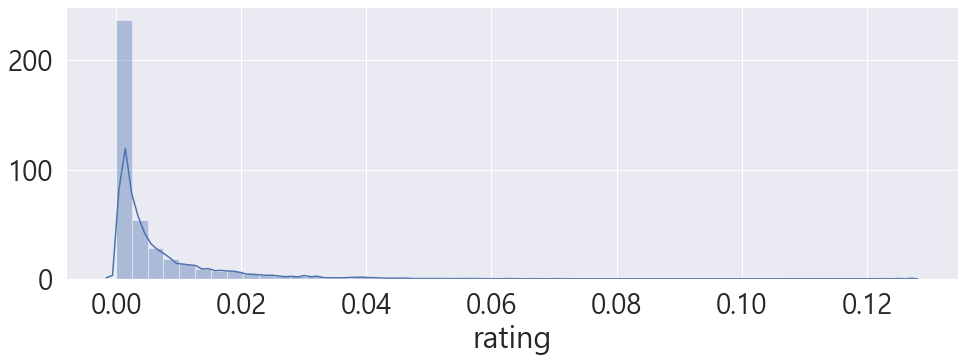

In [9]:
plt.figure(figsize = (16, 5))
sns.distplot(df_train['rating'])
plt.show()

- 시청률 변수의 분포를 확인해보니, "0"인 값들이 존재하는 것 같다.
- 따라서 시청률 변수 값이 "0"인 값들이 얼마나 되는지 확인해보자.

In [10]:
zero_rating = df_train[df_train['rating'] == 0]
zero_rating

,date,exp_mins,mom_code,pd_code,pd_name,pd_group,pd_price,sales,weekdays,seasons,rating,temp,rain,humidity,snow,dust,is_rain,is_snow,pd_count
0,2019-01-01 06:00:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0000,Tuesday,1,0.0000,-7.9000,nan,60.0000,nan,65.0000,0,0,53
1,2019-01-01 06:00:00,20.0000,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0000,Tuesday,1,0.0000,-7.9000,nan,60.0000,nan,65.0000,0,0,110
2,2019-01-01 06:20:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0000,Tuesday,1,0.0000,-7.9000,nan,60.0000,nan,65.0000,0,0,82
3,2019-01-01 06:20:00,20.0000,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0000,Tuesday,1,0.0000,-7.9000,nan,60.0000,nan,65.0000,0,0,175
4,2019-01-01 06:40:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0000,Tuesday,1,0.0000,-7.9000,nan,60.0000,nan,65.0000,0,0,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37355,2019-12-31 21:20:00,20.0000,100155,200489,무이자 LG전자 매직스페이스 냉장고,가전,1499000,20154000.0000,Tuesday,1,0.0000,-7.4000,nan,43.0000,nan,27.0000,0,0,14
37360,2019-12-31 23:20:00,20.0000,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,4573000.0000,Tuesday,1,0.0000,-7.4000,nan,45.0000,nan,24.0000,0,0,26
37361,2019-12-31 23:20:00,20.0000,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,9129000.0000,Tuesday,1,0.0000,-7.4000,nan,45.0000,nan,24.0000,0,0,55
37362,2019-12-31 23:20:00,20.0000,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,620000.0000,Tuesday,1,0.0000,-7.4000,nan,45.0000,nan,24.0000,0,0,4


- 결과를 살펴보면, 시청률이 0인데 취급액이 존재한다.
- 왜 이런 결과가 나왔을까??
    - TV 외에 다른 경로를 통해 구매했을 가능성이 존재한다.
    - 즉, 온라인으로 구매했을 가능성을 배제할 수 없다!!

## 시청률 추이 확인

### date 변수 쪼개기
- EDA를 위해 date 변수를 활용하여, "월(month), 일(day), 시간(hour)" 변수를 만들어주도록 하겠다.
- 따라서 먼저 object 타입으로 되어있는 date 변수를 datetime 타입으로 변경해 준 뒤, "월/일/시간" 변수들을 만들어주도록 하겠다.

In [11]:
df_train['date'] = pd.to_datetime(df_train['date'], format = '%Y-%m-%d %H:%M:%S')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      37372 non-null  datetime64[ns]
 1   exp_mins  37372 non-null  float64       
 2   mom_code  37372 non-null  int64         
 3   pd_code   37372 non-null  int64         
 4   pd_name   37372 non-null  object        
 5   pd_group  37372 non-null  object        
 6   pd_price  37372 non-null  int64         
 7   sales     37372 non-null  float64       
 8   weekdays  37372 non-null  object        
 9   seasons   37372 non-null  int64         
 10  rating    37372 non-null  float64       
 11  temp      37372 non-null  float64       
 12  rain      3489 non-null   float64       
 13  humidity  37372 non-null  float64       
 14  snow      368 non-null    float64       
 15  dust      34952 non-null  float64       
 16  is_rain   37372 non-null  int64         
 17  is_snow   37

In [12]:
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['hour'] = df_train['date'].dt.hour

df_train.head()

,date,exp_mins,mom_code,pd_code,pd_name,pd_group,pd_price,sales,weekdays,seasons,...,rain,humidity,snow,dust,is_rain,is_snow,pd_count,month,day,hour
0,2019-01-01 06:00:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0000,Tuesday,1,...,nan,60.0000,nan,65.0000,0,0,53,1,1,6
1,2019-01-01 06:00:00,20.0000,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0000,Tuesday,1,...,nan,60.0000,nan,65.0000,0,0,110,1,1,6
2,2019-01-01 06:20:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0000,Tuesday,1,...,nan,60.0000,nan,65.0000,0,0,82,1,1,6
3,2019-01-01 06:20:00,20.0000,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0000,Tuesday,1,...,nan,60.0000,nan,65.0000,0,0,175,1,1,6
4,2019-01-01 06:40:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0000,Tuesday,1,...,nan,60.0000,nan,65.0000,0,0,168,1,1,6


### 월별(month) / 일별(day) / 시간대별(hour) / 요일별(weekdays) / 계절별(seasons) 시청률 추이

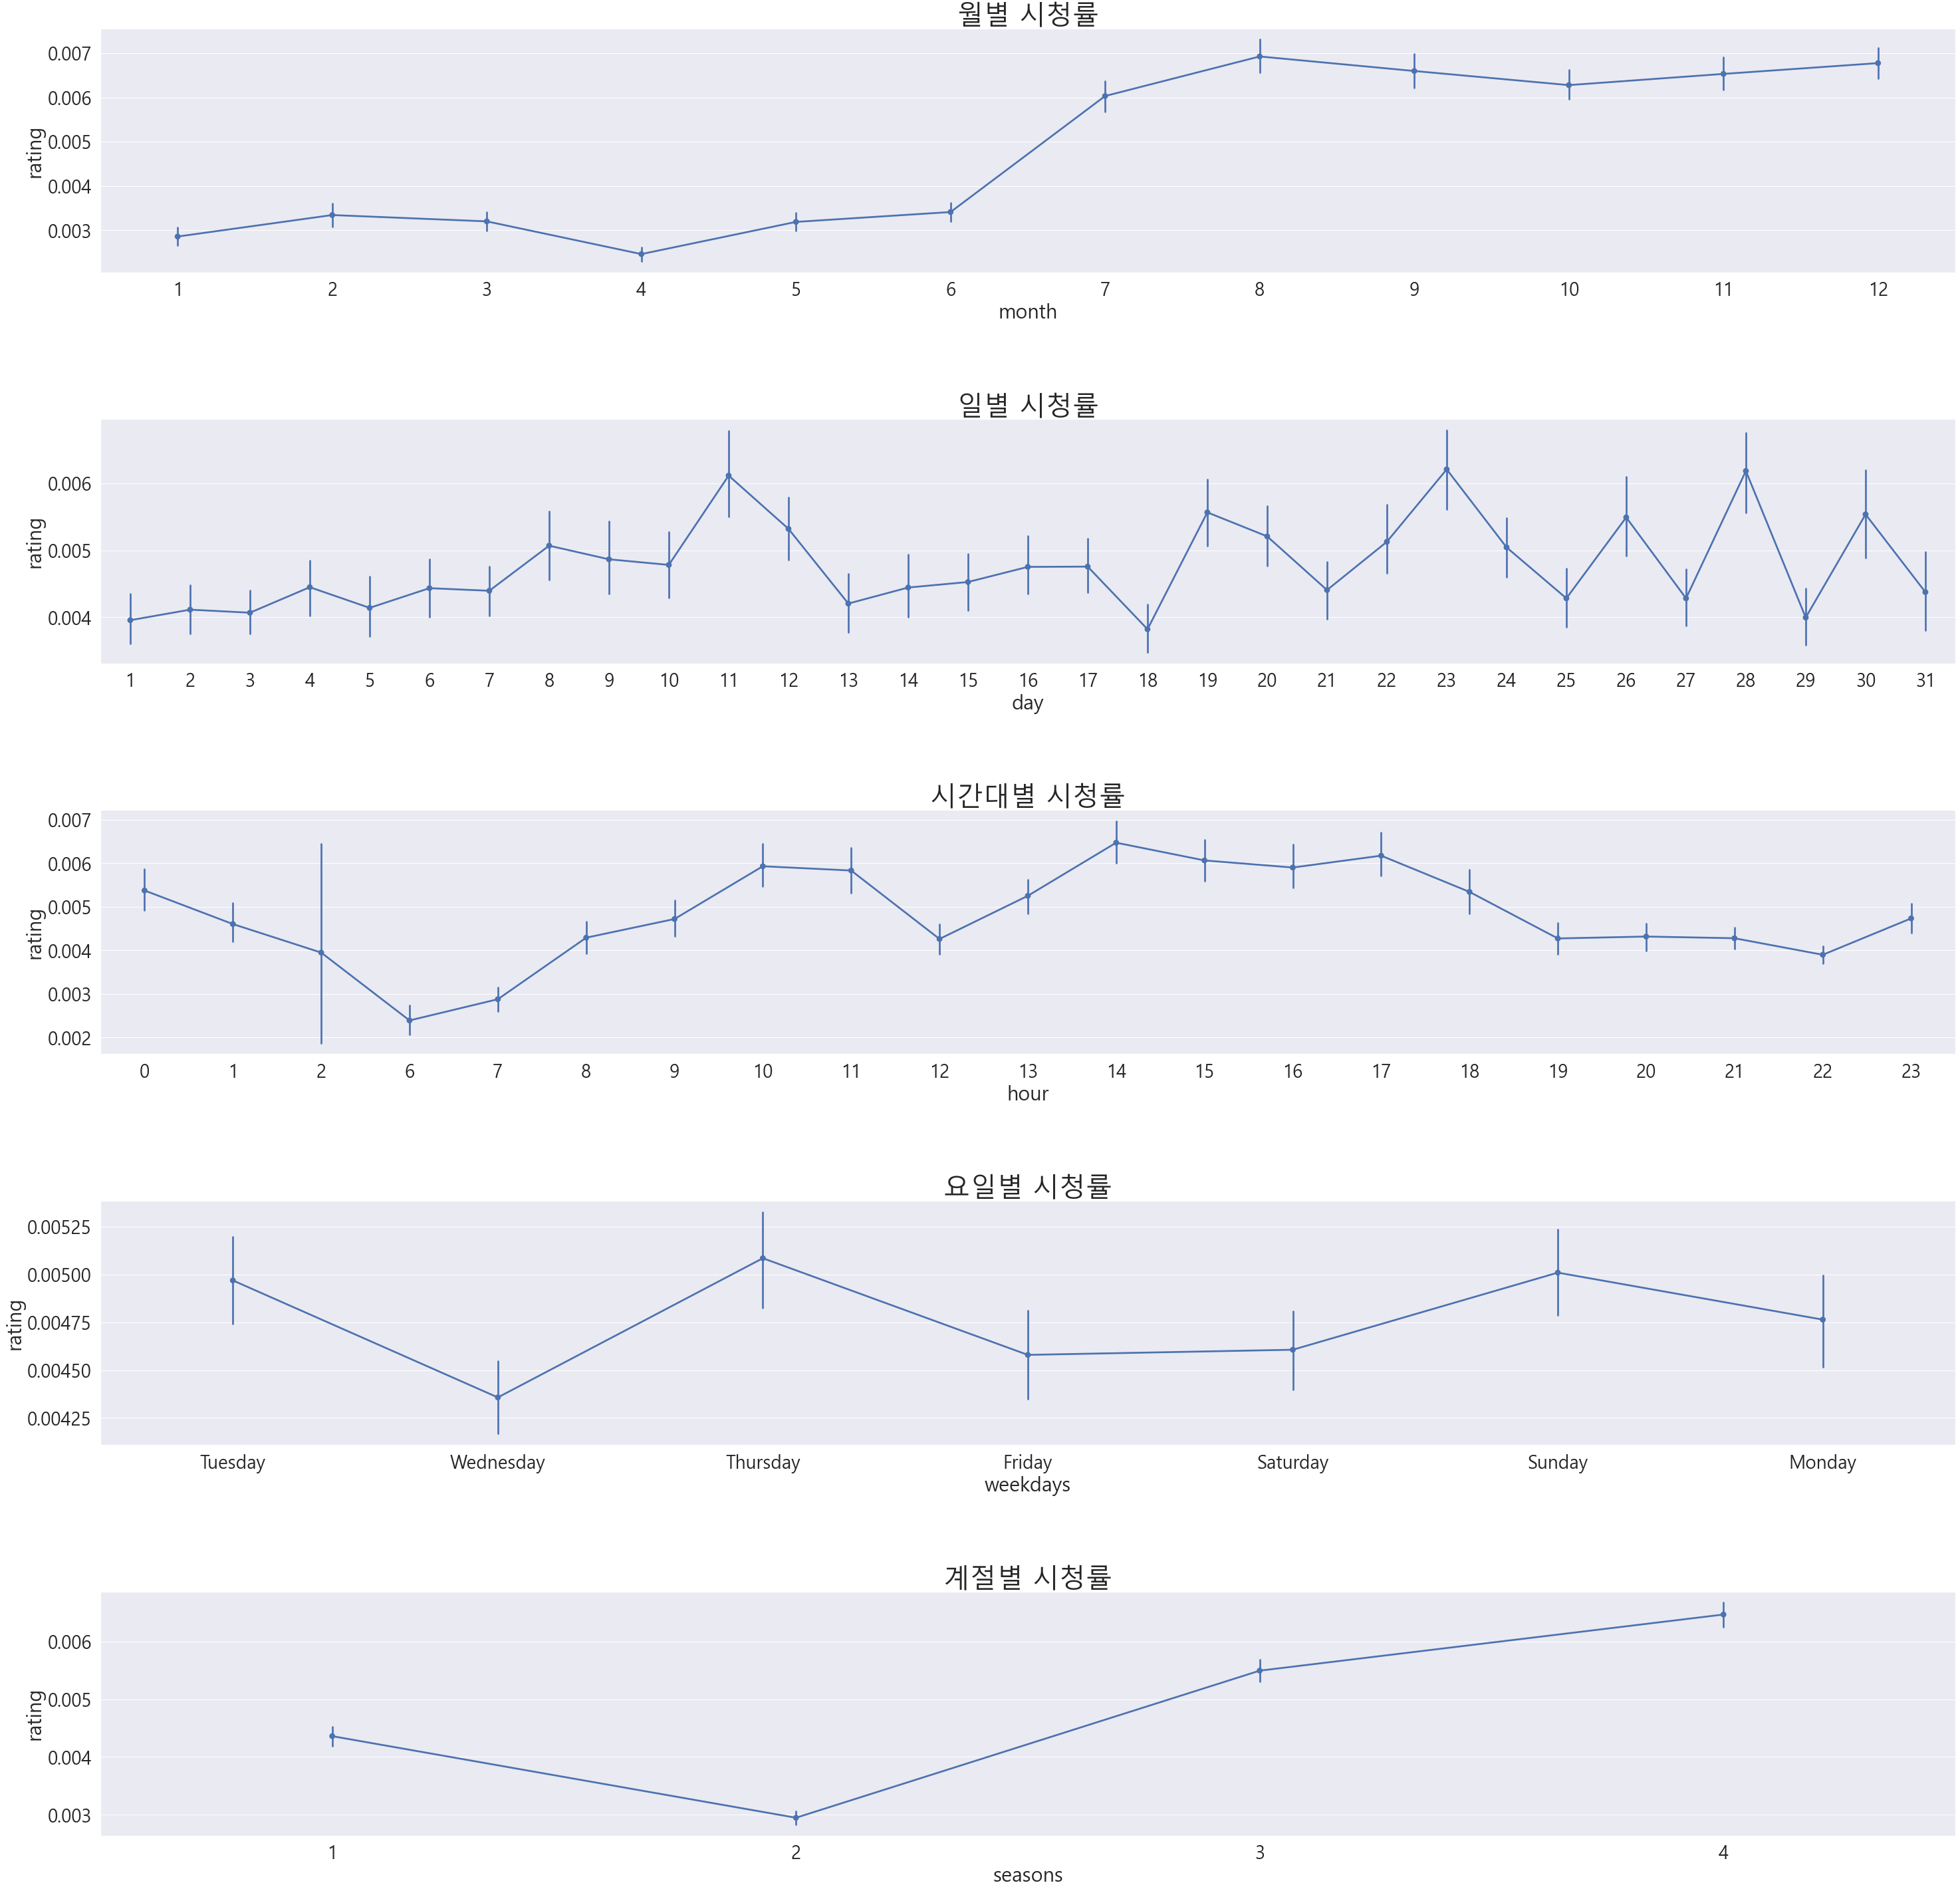

In [13]:
f,(ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5)
f.set_size_inches(50, 50)

# 1. 월별(month) 시청률
sns.pointplot(data = df_train, x = 'month', y = 'rating', ax = ax1)
# 2. 일별(day) 시청률
sns.pointplot(data = df_train, x = 'day', y = 'rating', ax = ax2)
# 3. 시간대별(hour) 시청률
sns.pointplot(data = df_train, x = 'hour', y = 'rating', ax = ax3)
# 4. 요일별(weekdays) 시청률
sns.pointplot(data = df_train, x = 'weekdays', y = 'rating', ax = ax4)
# 5. 계절별(seasons) 시청률
sns.pointplot(data = df_train, x = 'seasons', y = 'rating', ax = ax5)

ax1.set_title('월별 시청률', fontsize = 40)
ax2.set_title('일별 시청률', fontsize = 40)
ax3.set_title('시간대별 시청률', fontsize = 40)
ax4.set_title('요일별 시청률', fontsize = 40)
ax5.set_title('계절별 시청률', fontsize = 40)

plt.subplots_adjust(hspace = 0.6) # 각각의 subplot들이 겹치지 않도록 세로 공간을 조정
plt.show()

**<시청률 추이 결과 해석>**

**1. 월별 시청률 추이**
    - 1 ~ 6월까지는 시청률이 비교적 낮으나, 7월부터 시청률이 증가해서 12월까지 비교적 높은 시청률이 유지되는 것을 알 수 있다.
    - 다시 말해 상반기에는 시청률이 비교적 낮은데, 하반기에는 시청률이 비교적 높다.
**2. 일별 시청률 추이**
    - 이걸 보는 건 큰 의미가 없을 것 같다...
**3. 시간대별 시청률 추이**
    - 일어나서 활발하게(?) 활동하는 시간대인 10 ~ 11시에 시청률이 높으며, 점심시간이 끝난 14시부터 17시까지 비교적 높은 시청률이 유지되는 것을 알 수 있다.
    - 한 가지 특이한 점은 새벽 시간대(0 ~ 2시)에도 생각보다 높은 시청률을 보인다는 것이다.
        - 물론 새벽 2시의 경우, 편차가 심한 편이긴 하다.
**4. 요일별 시청률 추이**
    - 수요일의 시청률이 가장 낮고, 화요일/목요일/일요일의 시청률이 비교적 높다.
**5. 계절별 시청률 추이**
    - 봄에 시청률이 가장 낮고, 여름부터 시청률이 증가하는 추세를 보이며 가을에 시청률이 가장 높다.
        - 이는 위에서 확인한 월별 시청률 추이와 유사한 결과이다.
        - 그렇다면 "하반기" 또는 "가을"에 유독 시청률이 높은 이유가 뭘까??

#### 월(month) 변수 범주화
- 월별(month) 시청률 추이를 살펴보니, 크게 **"상반기"와 "하반기"로 범주화**를 해 줄 필요가 있어보인다.
- 따라서 다음과 같이 2개의 범주로 범주화 해주도록 하겠다.
    - **상반기**: 1 ~ 6월
    - **하반기**: 7 ~ 12월

In [14]:
def category_month(x):
    if x >= 1 and x <= 6:
        return '상반기'
    else:
        return '하반기'

df_train['month_cat'] = df_train['month'].apply(category_month)
df_train.month_cat.value_counts()

상반기    18925
하반기    18447
Name: month_cat, dtype: int64

- 이제 month_cat 변수에 대하여 시청률 추이를 다시 확인해보도록 하겠다!
    - 즉, 상반기와 하반기로 나눠서 시청률 추이를 살펴보겠다.

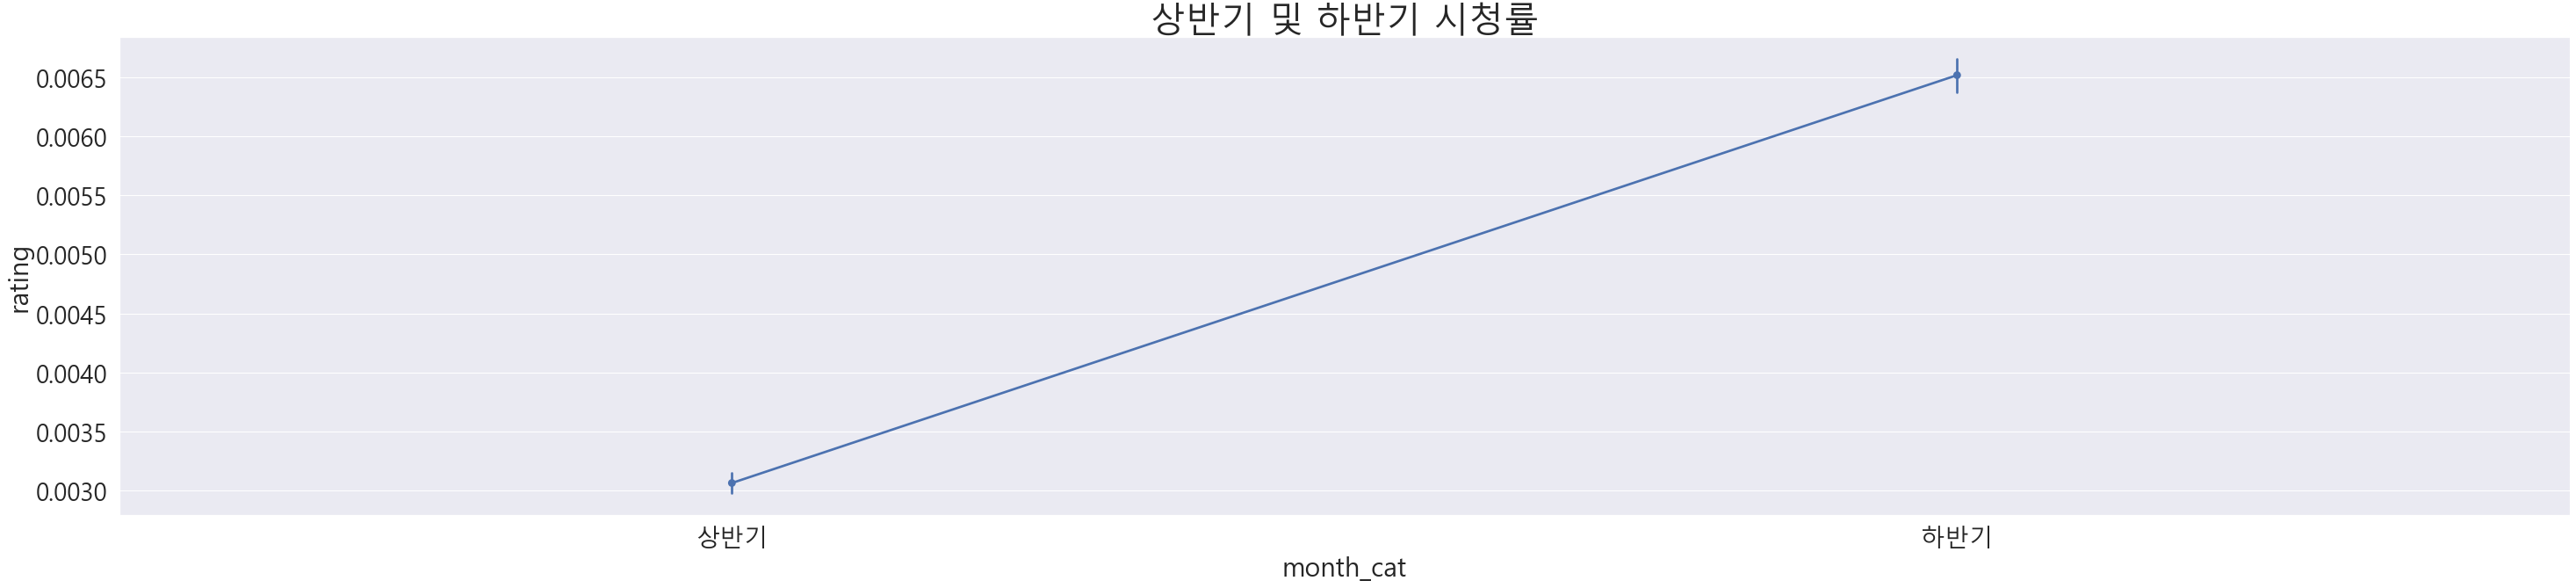

In [15]:
f, ax1 = plt.subplots(nrows = 1)
f.set_size_inches(50, 10)

sns.pointplot(data = df_train, x = 'month_cat', y = 'rating', ax = ax1)
ax1.set_title('상반기 및 하반기 시청률', fontsize = 40)

plt.show()

- 그래프를 보면 알 수 있듯이, 상반기와 하반기의 시청률 차이가 크다는 것을 알 수 있다.

#### 시간(hour) 변수 범주화
- 시간대별(hour) 시청률 추이를 살펴보니, **시간대별로 범주화**를 해 줄 필요가 있어보인다.
- 따라서 다음과 같이 **4개의 범주로 범주화** 해주도록 하겠다.
    - **오전**: 06:00:00 ~ 12:00:00
    - **오후**: 12:00:00 ~ 18:00:00
    - **밤**: 18:00:00 ~ 00:00:00
    - **심야**: 00:00:00 ~ 02:00:00
- <참고>
    - 02:00:00 부터 06:00:00 까지는 편성된 방송이 없음을 고려해서 범주화 해주어야 한다.

In [16]:
def category_hour(x):
    if x >= 6 and x < 12:
        return '오전'
    elif x >= 12 and x < 18:
        return '오후'
    elif x >= 18 and x < 23:
        return '밤'
    else:
        return '심야'

df_train['hour_cat'] = df_train['hour'].apply(category_hour)
df_train.hour_cat.value_counts()

밤     12571
오전     9895
오후     9501
심야     5405
Name: hour_cat, dtype: int64

- 이제 hour_cat 변수에 대하여 시청률 추이를 다시 확인해보도록 하겠다!

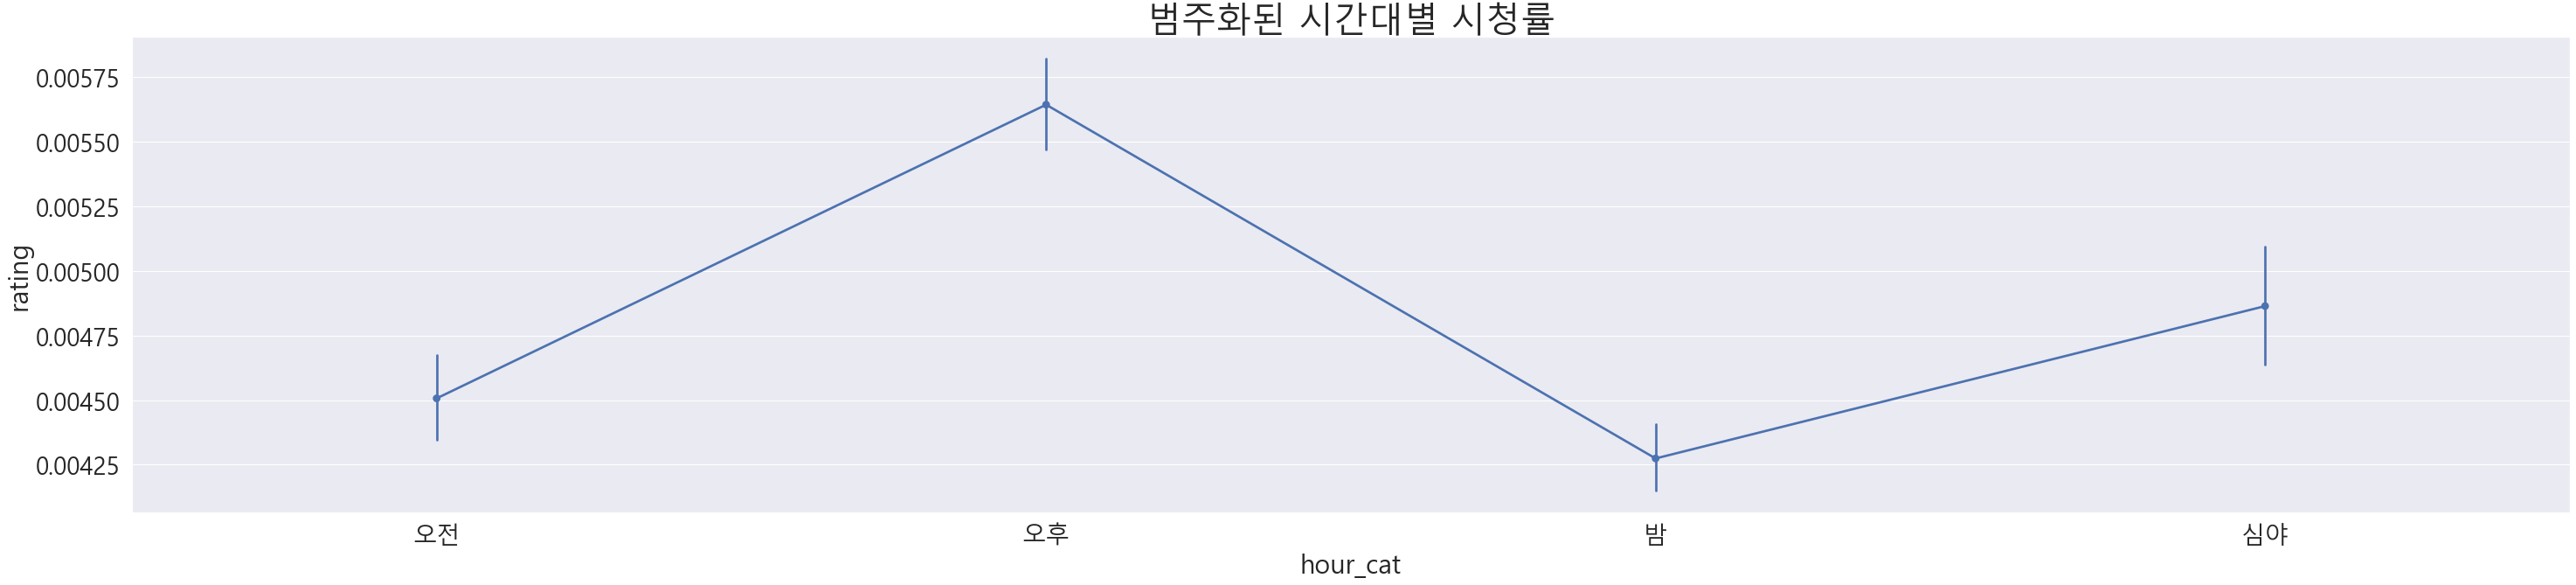

In [17]:
f, ax1 = plt.subplots(nrows = 1)
f.set_size_inches(50, 10)

sns.pointplot(data = df_train, x = 'hour_cat', y = 'rating', ax = ax1)
ax1.set_title('범주화된 시간대별 시청률', fontsize = 40)

plt.show()

- 결과를 살펴보면 "오후" 시간대에 시청률이 가장 높고, "밤" 시간대에 시청률이 가장 낮다.
    - 처음엔 퇴근 후의 시간대인 "밤"에 시청률이 가장 높을 것으로 예상했으나, 실제 그래프를 그려보니 "오후" 시간대가 시청률이 가장 높았다.
    - 왜 이러한 결과가 나왔을까??
        - "오후" 시간대에 많은 주부님들이 TV를 볼 것임 (+ "오후" 시간대에는 재미있는 다른 채널들이 몇 개 존재하지 않음)
        - 퇴근하고 집와서 굳이 홈쇼핑을 볼 필요가 있을까..? 재밌는 다른 채널들도 많은데..?
    - **재핑타임**을 고려한 파생 변수 하나를 만들어주면 좋을 것 같다.
        - 추후에 편성 시간표를 짤 때 도움이 될 듯!!

#### 봄에 시청률이 현저히 낮고, 여름과 가을에 유독 시청률이 높은 이유는?
- 이를 확인해보기 위해, 각 계절별로 데이터 셋을 분할해서 어떤 상품군을 많이 방송하는지 확인해보겠다.

- 각 계절별로 데이터 셋을 분할하기 전에, 먼저 총 몇 개의 상품군이 존재하는지 확인해보겠다.

In [18]:
df_train.pd_group.value_counts()

주방      6604
가전      6479
의류      4340
속옷      3919
잡화      3891
농수축     3884
생활용품    2877
가구      2614
이미용     1305
건강기능     790
침구       669
Name: pd_group, dtype: int64

- 확인해보면 **총 11개의 상품군**이 존재함을 알 수 있다.
- 이제 "겨울", "봄", "여름", "가을"에 해당하는 데이터 셋을 각각 새로 만들어주겠다.

In [19]:
df_winter = df_train[(df_train['seasons'] == 2)] # 겨울
df_spring = df_train[(df_train['seasons'] == 2)] # 봄
df_summer = df_train[(df_train['seasons'] == 3)] # 여름
df_autumn = df_train[(df_train['seasons'] == 4)] # 가을

In [20]:
# "겨울" 데이터 셋의 상품군
pd_group_1 = pd.DataFrame(df_winter.pd_group.value_counts()).reset_index()
pd_group_1.rename(columns = {'index':'pd_group', 'pd_group':'count_winter'}, inplace = True) # 컬럼명 변경
# "봄" 데이터 셋의 상품군
pd_group_2 = pd.DataFrame(df_spring.pd_group.value_counts()).reset_index()
pd_group_2.rename(columns = {'index':'pd_group', 'pd_group':'count_spring'}, inplace = True) # 컬럼명 변경
# "여름" 데이터 셋의 상품군
pd_group_3 = pd.DataFrame(df_summer.pd_group.value_counts()).reset_index()
pd_group_3.rename(columns = {'index':'pd_group', 'pd_group':'count_summer'}, inplace = True) # 컬럼명 변경
# "가을" 데이터 셋의 상품군
pd_group_4 = pd.DataFrame(df_autumn.pd_group.value_counts()).reset_index()
pd_group_4.rename(columns = {'index':'pd_group', 'pd_group':'count_autumn'}, inplace = True) # 컬렴명 변경

# 계절별 데이터 셋의 상품군 개수가 동일한지 확인
len(pd_group_1), len(pd_group_2), len(pd_group_3), len(pd_group_4)

(11, 11, 11, 11)

- 마지막으로 계절별로 분할되어 있는 데이터 셋들을 pd_group 변수를 조인키로 사용하여 inner join 해주도록 하겠다.

In [21]:
# 여러 개의 데이터 프레임을 리스트에 담아주기
dfs = [pd_group_1, pd_group_2, pd_group_3, pd_group_4]
# reduce 패키지와 lambda 식을 사용하여 여러 개의 데이터 프레임을 한 번에 merge!!
pd_group_compare = reduce(lambda left, right: pd.merge(left, right, how = 'inner', on = 'pd_group'), dfs)
pd_group_compare

,pd_group,count_winter,count_spring,count_summer,count_autumn
0,가전,2516,2516,1616,915
1,주방,1777,1777,1518,1423
2,의류,1438,1438,1004,930
3,속옷,1109,1109,1055,714
4,가구,909,909,693,631
5,잡화,831,831,1250,1247
6,농수축,624,624,1042,1152
7,생활용품,534,534,521,1057
8,이미용,199,199,233,477
9,건강기능,151,151,204,255


**<"계절", "상품군", 그리고 "시청률"의 관계>**
- 위 결과에서 "봄"과 "가을"에 많이 방송하는 상품군을 비교해보면, 크게 두 가지 point를 발견할 수 있다.
    1. **시청률이 낮은 봄**에는 **"가전, 의류, 속옷"** 상품군을 많이 방송한다.
    2. **시청률이 높은 가을**에는 **"잡화, 농수축, 생활용품"** 상품군을 많이 방송한다.
- 이러한 결과를 통해 어떠한 insight를 도출할 수 있을까??
    - 추가적으로 **시간대별 상품군별 시청률**을 확인해 볼 필요가 있어보인다.

**<참고>**
- **"주방"** 상품군의 경우, **모든 계절에 대하여 비교적 방송 횟수가 비슷**하므로 따로 issue로 보지 않았다.

- 그럼 이제 상품군별 시간대별 시청률을 확인해보자.
    - 위에서 **시청률이 낮은 봄**에는 **"가전, 의류, 속옷"** 상품군을 많이 방송하고, **시청률이 높은 가을**에는 **"잡화, 농수축, 생활용품"** 상품군을 많이 방송하는 것을 확인했다.
    - 우선은 모든 상품군들에 대해서 시간대별 시청률을 확인해보도록 하겠다.

In [22]:
# 상품군별(pd_group)로 데이터 셋을 총 11개로 분할
df_kitchen = df_train[(df_train['pd_group'] == '주방')]
df_elec = df_train[(df_train['pd_group'] == '가전')]
df_clothes = df_train[(df_train['pd_group'] == '의류')]
df_underwear = df_train[(df_train['pd_group'] == '속옷')]
df_etc = df_train[(df_train['pd_group'] == '잡화')]
df_agri = df_train[(df_train['pd_group'] == '농수축')]
df_supply = df_train[(df_train['pd_group'] == '생활용품')]
df_furniture = df_train[(df_train['pd_group'] == '가구')]
df_beauty = df_train[(df_train['pd_group'] == '이미용')]
df_health = df_train[(df_train['pd_group'] == '건강기능')]
df_bed = df_train[(df_train['pd_group'] == '침구')]

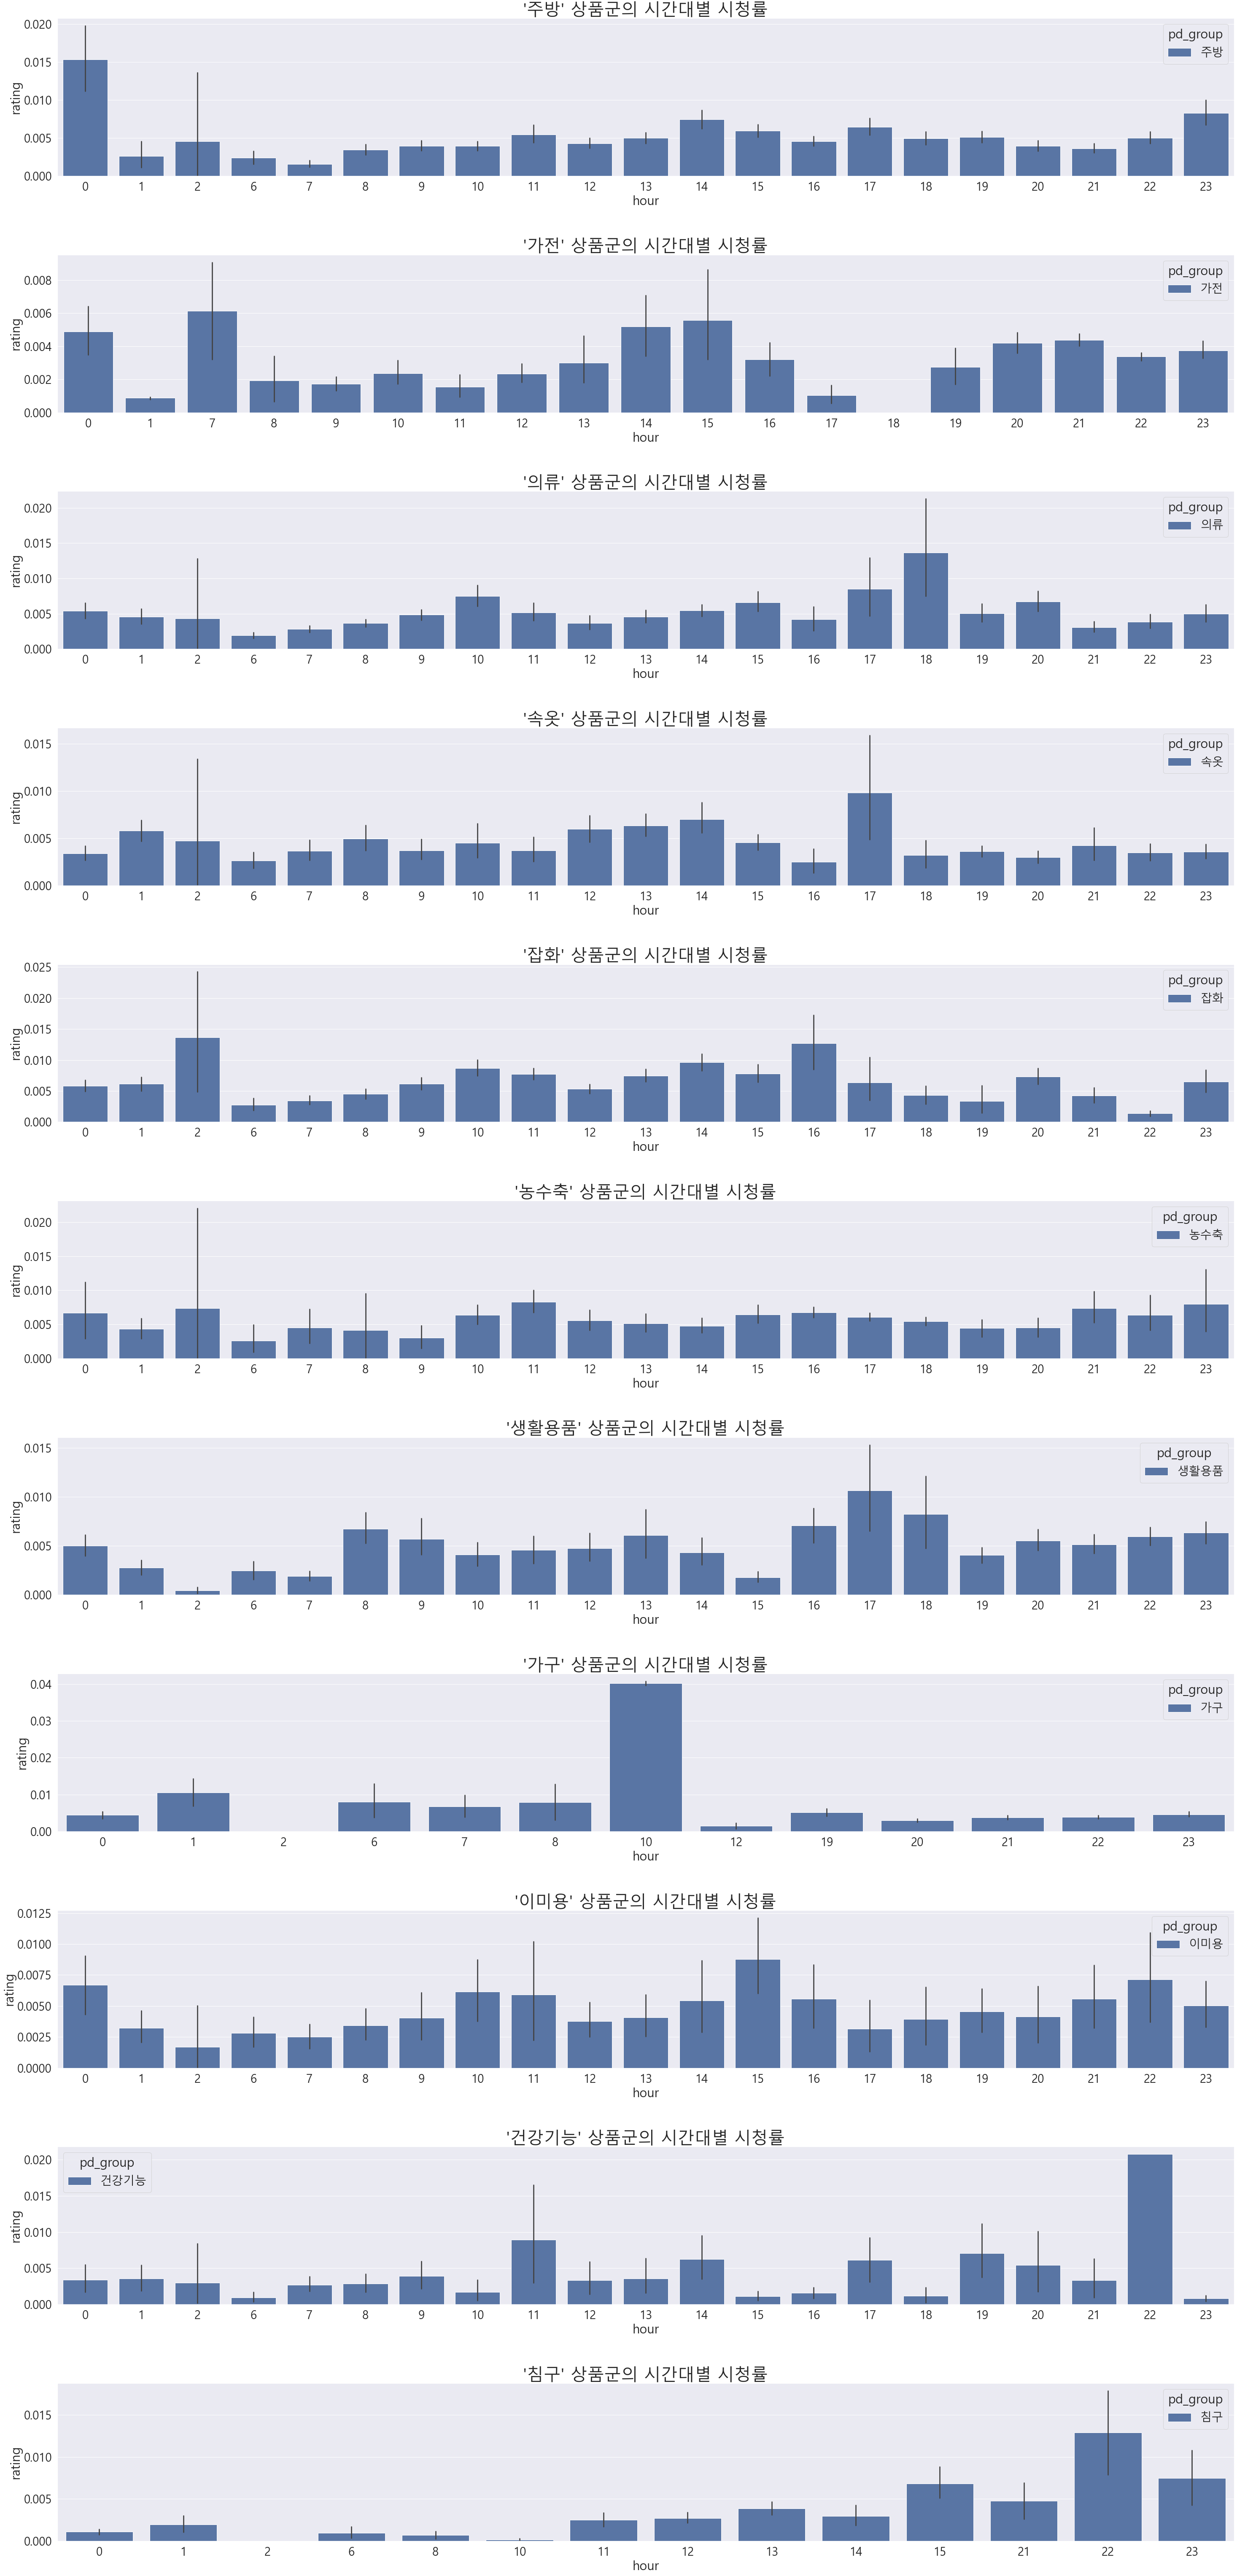

In [23]:
# 1. 시간대별 상품군별 시청률
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = plt.subplots(nrows = 11)
f.set_size_inches(50, 110)

sns.barplot(data = df_kitchen, x = 'hour', y = 'rating', hue = 'pd_group', ax = ax1)
sns.barplot(data = df_elec, x = 'hour', y = 'rating', hue = 'pd_group', ax = ax2)
sns.barplot(data = df_clothes, x = 'hour', y = 'rating', hue = 'pd_group', ax = ax3)
sns.barplot(data = df_underwear, x = 'hour', y = 'rating', hue = 'pd_group', ax = ax4)
sns.barplot(data = df_etc, x = 'hour', y = 'rating', hue = 'pd_group', ax = ax5)
sns.barplot(data = df_agri, x = 'hour', y = 'rating', hue = 'pd_group', ax = ax6)
sns.barplot(data = df_supply, x = 'hour', y = 'rating', hue = 'pd_group', ax = ax7)
sns.barplot(data = df_furniture, x = 'hour', y = 'rating', hue = 'pd_group', ax = ax8)
sns.barplot(data = df_beauty, x = 'hour', y = 'rating', hue = 'pd_group', ax = ax9)
sns.barplot(data = df_health, x = 'hour', y = 'rating', hue = 'pd_group', ax = ax10)
sns.barplot(data = df_bed, x = 'hour', y = 'rating', hue = 'pd_group', ax = ax11)

ax1.set_title("'주방' 상품군의 시간대별 시청률", fontsize = 40)
ax2.set_title("'가전' 상품군의 시간대별 시청률", fontsize = 40)
ax3.set_title("'의류' 상품군의 시간대별 시청률", fontsize = 40)
ax4.set_title("'속옷' 상품군의 시간대별 시청률", fontsize = 40)
ax5.set_title("'잡화' 상품군의 시간대별 시청률", fontsize = 40)
ax6.set_title("'농수축' 상품군의 시간대별 시청률", fontsize = 40)
ax7.set_title("'생활용품' 상품군의 시간대별 시청률", fontsize = 40)
ax8.set_title("'가구' 상품군의 시간대별 시청률", fontsize = 40)
ax9.set_title("'이미용' 상품군의 시간대별 시청률", fontsize = 40)
ax10.set_title("'건강기능' 상품군의 시간대별 시청률", fontsize = 40)
ax11.set_title("'침구' 상품군의 시간대별 시청률", fontsize = 40)

for i in range(11):
    ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]
    ax[i].legend(title = 'pd_group', frameon = True, title_fontsize = 30)

plt.subplots_adjust(hspace = 0.5) # 각각의 subplot들이 겹치지 않도록 세로 공간을 조정
plt.show()

- **각 상품군의 시간대별 시청률**만 봐서는 얻어낼 수 있는 insight가 많지 않다고 판단했다.
    - 위 그래프를 통해 **"시청률이 높으면 시청자들이 상품 구매를 많이 할까?"**라는 가설을 세워보았다.
    - 해당 가설을 검증해보기 위해, **시간대별(hour) 각 상품군의 판매량**을 확인해보겠다.

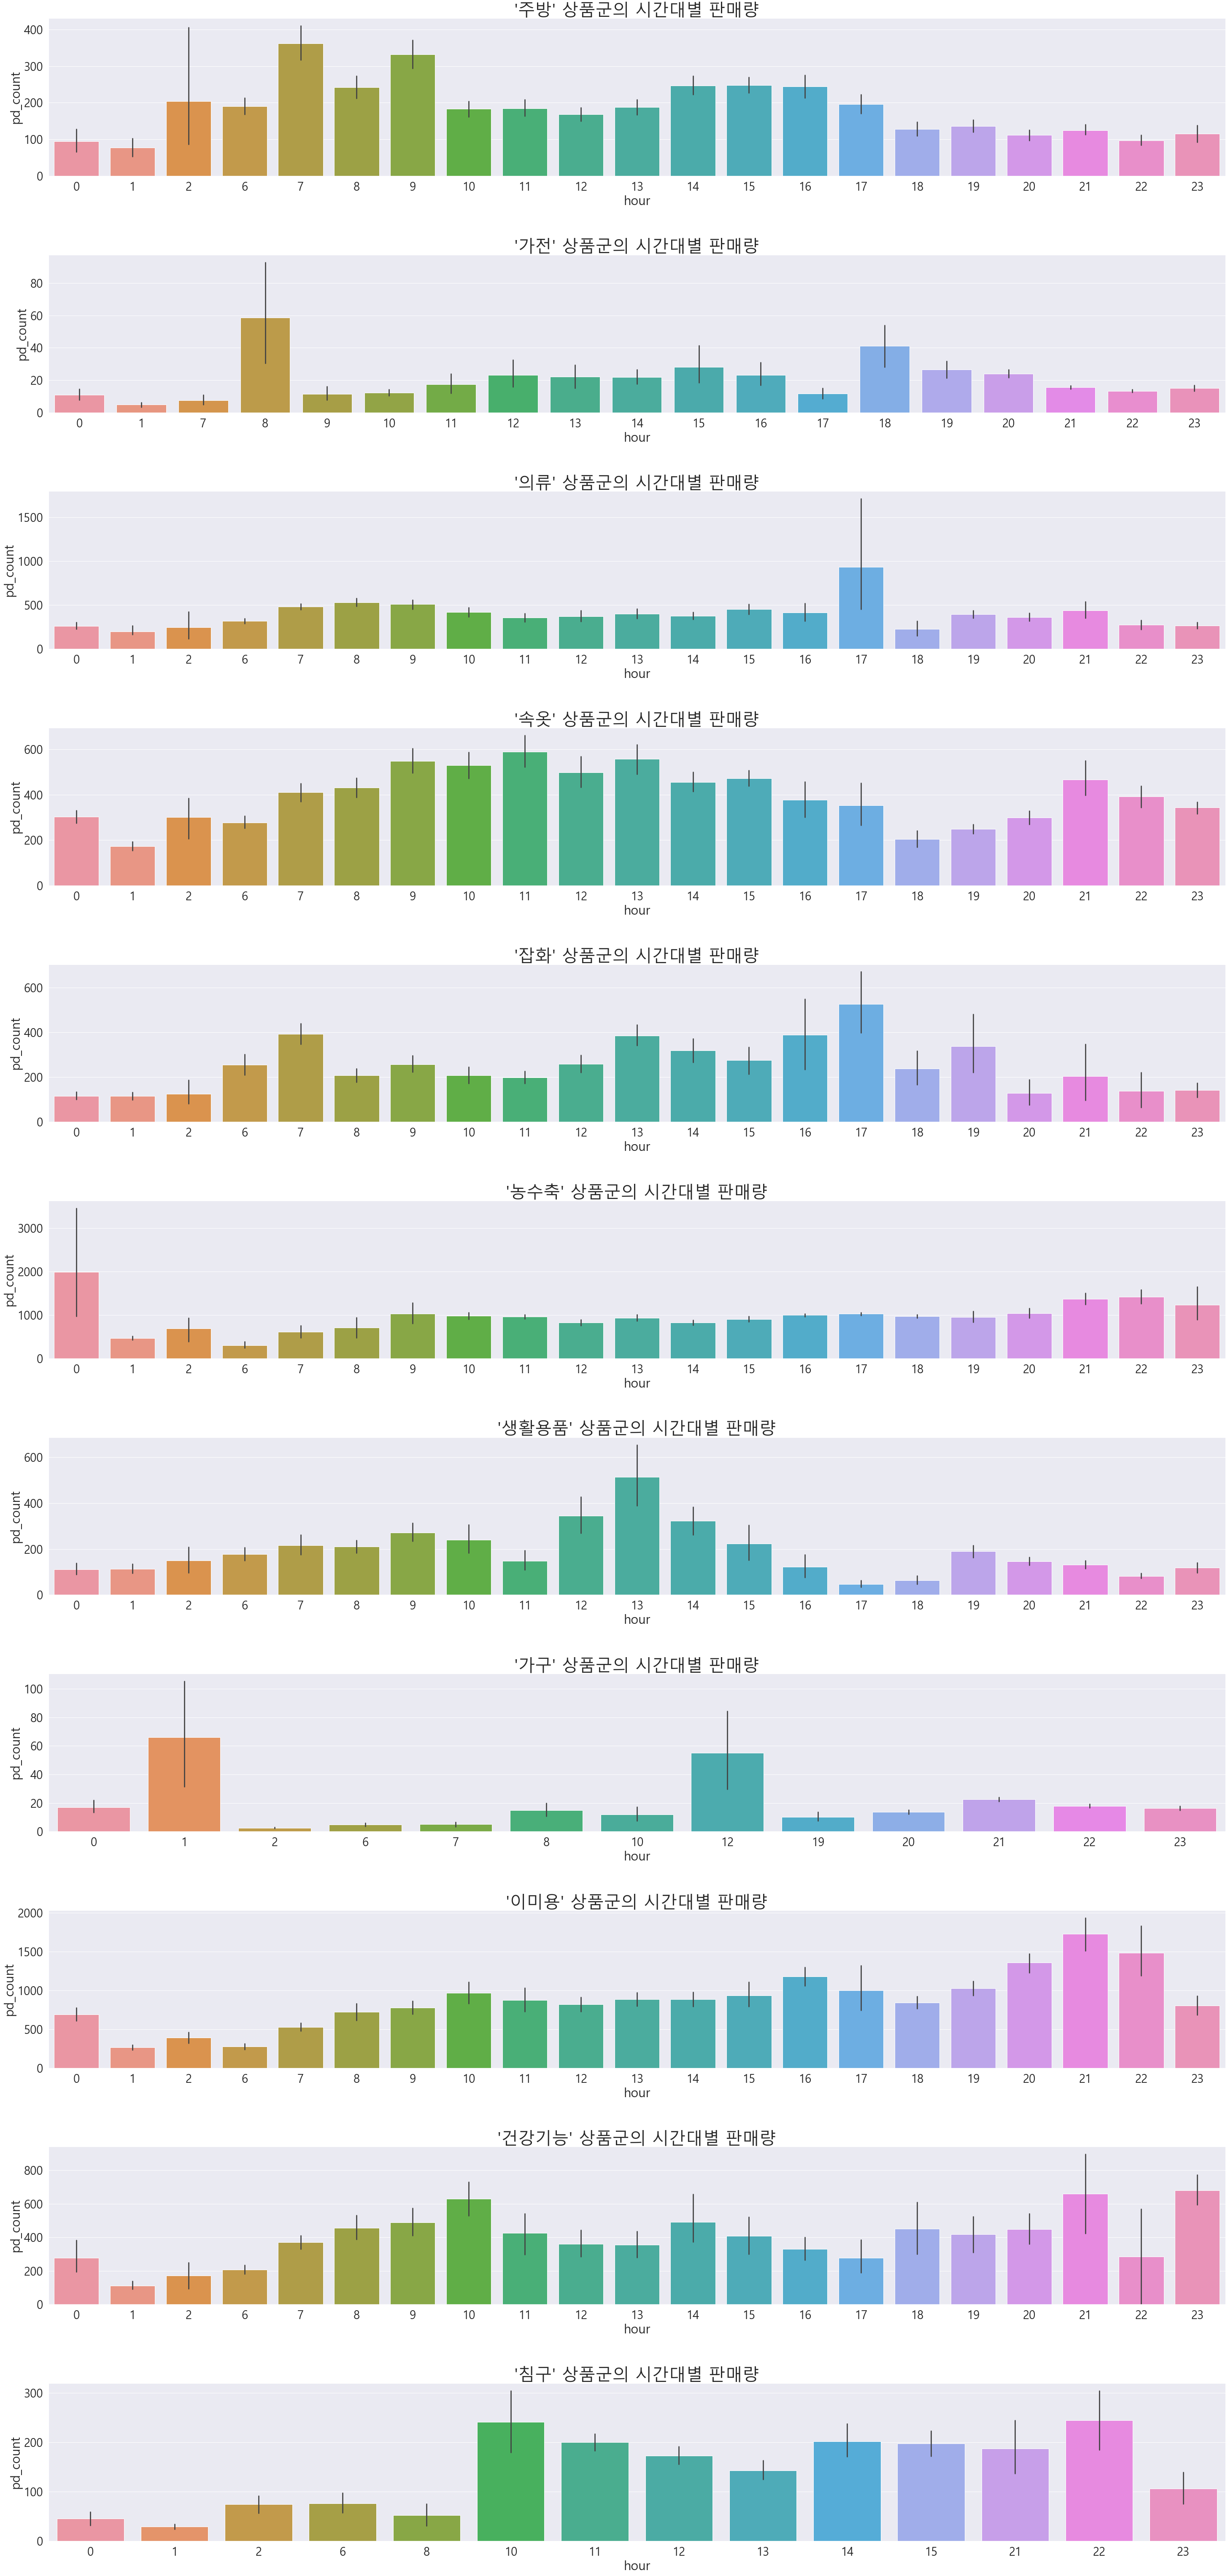

In [24]:
# 2. 시간대별(hour) 각 상품군의 판매량
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = plt.subplots(nrows = 11)
f.set_size_inches(50, 110)

sns.barplot(data = df_kitchen, x = 'hour', y = 'pd_count', ax = ax1)
sns.barplot(data = df_elec, x = 'hour', y = 'pd_count', ax = ax2)
sns.barplot(data = df_clothes, x = 'hour', y = 'pd_count', ax = ax3)
sns.barplot(data = df_underwear, x = 'hour', y = 'pd_count', ax = ax4)
sns.barplot(data = df_etc, x = 'hour', y = 'pd_count', ax = ax5)
sns.barplot(data = df_agri, x = 'hour', y = 'pd_count', ax = ax6)
sns.barplot(data = df_supply, x = 'hour', y = 'pd_count', ax = ax7)
sns.barplot(data = df_furniture, x = 'hour', y = 'pd_count', ax = ax8)
sns.barplot(data = df_beauty, x = 'hour', y = 'pd_count', ax = ax9)
sns.barplot(data = df_health, x = 'hour', y = 'pd_count', ax = ax10)
sns.barplot(data = df_bed, x = 'hour', y = 'pd_count', ax = ax11)

ax1.set_title("'주방' 상품군의 시간대별 판매량", fontsize = 40)
ax2.set_title("'가전' 상품군의 시간대별 판매량", fontsize = 40)
ax3.set_title("'의류' 상품군의 시간대별 판매량", fontsize = 40)
ax4.set_title("'속옷' 상품군의 시간대별 판매량", fontsize = 40)
ax5.set_title("'잡화' 상품군의 시간대별 판매량", fontsize = 40)
ax6.set_title("'농수축' 상품군의 시간대별 판매량", fontsize = 40)
ax7.set_title("'생활용품' 상품군의 시간대별 판매량", fontsize = 40)
ax8.set_title("'가구' 상품군의 시간대별 판매량", fontsize = 40)
ax9.set_title("'이미용' 상품군의 시간대별 판매량", fontsize = 40)
ax10.set_title("'건강기능' 상품군의 시간대별 판매량", fontsize = 40)
ax11.set_title("'침구' 상품군의 시간대별 판매량", fontsize = 40)

plt.subplots_adjust(hspace = 0.5) # 각각의 subplot들이 겹치지 않도록 세로 공간을 조정
plt.show()

- 시간대별 각 상품군의 판매량을 살펴보니, **"시청률이 높으면 시청자들이 상품 구매를 많이 할까?"**라는 가설은 옳지 않았다는 것을 알 수 있다.
    - 시청률이 낮아도 판매량이 높은 경우들이 존재하기 때문!!
    - 추후에 시청률(rating)과 취급액(sales)의 상관관계를 피어슨 상관계수를 통해 다시 한 번 확인해보도록 하겠다.
- 다음으로 **범주화된 시간대별(hour_cat)로 각 상품군의 판매량**을 확인해보겠다.

In [25]:
# 범주화된 시간대별(hour_cat)로 데이터 셋을 4개로 분할
df_morning = df_train[df_train['hour_cat'] == '오전']
df_afternoon = df_train[df_train['hour_cat'] == '오후']
df_night = df_train[df_train['hour_cat'] == '밤']
df_late_at_night = df_train[df_train['hour_cat'] == '심야']

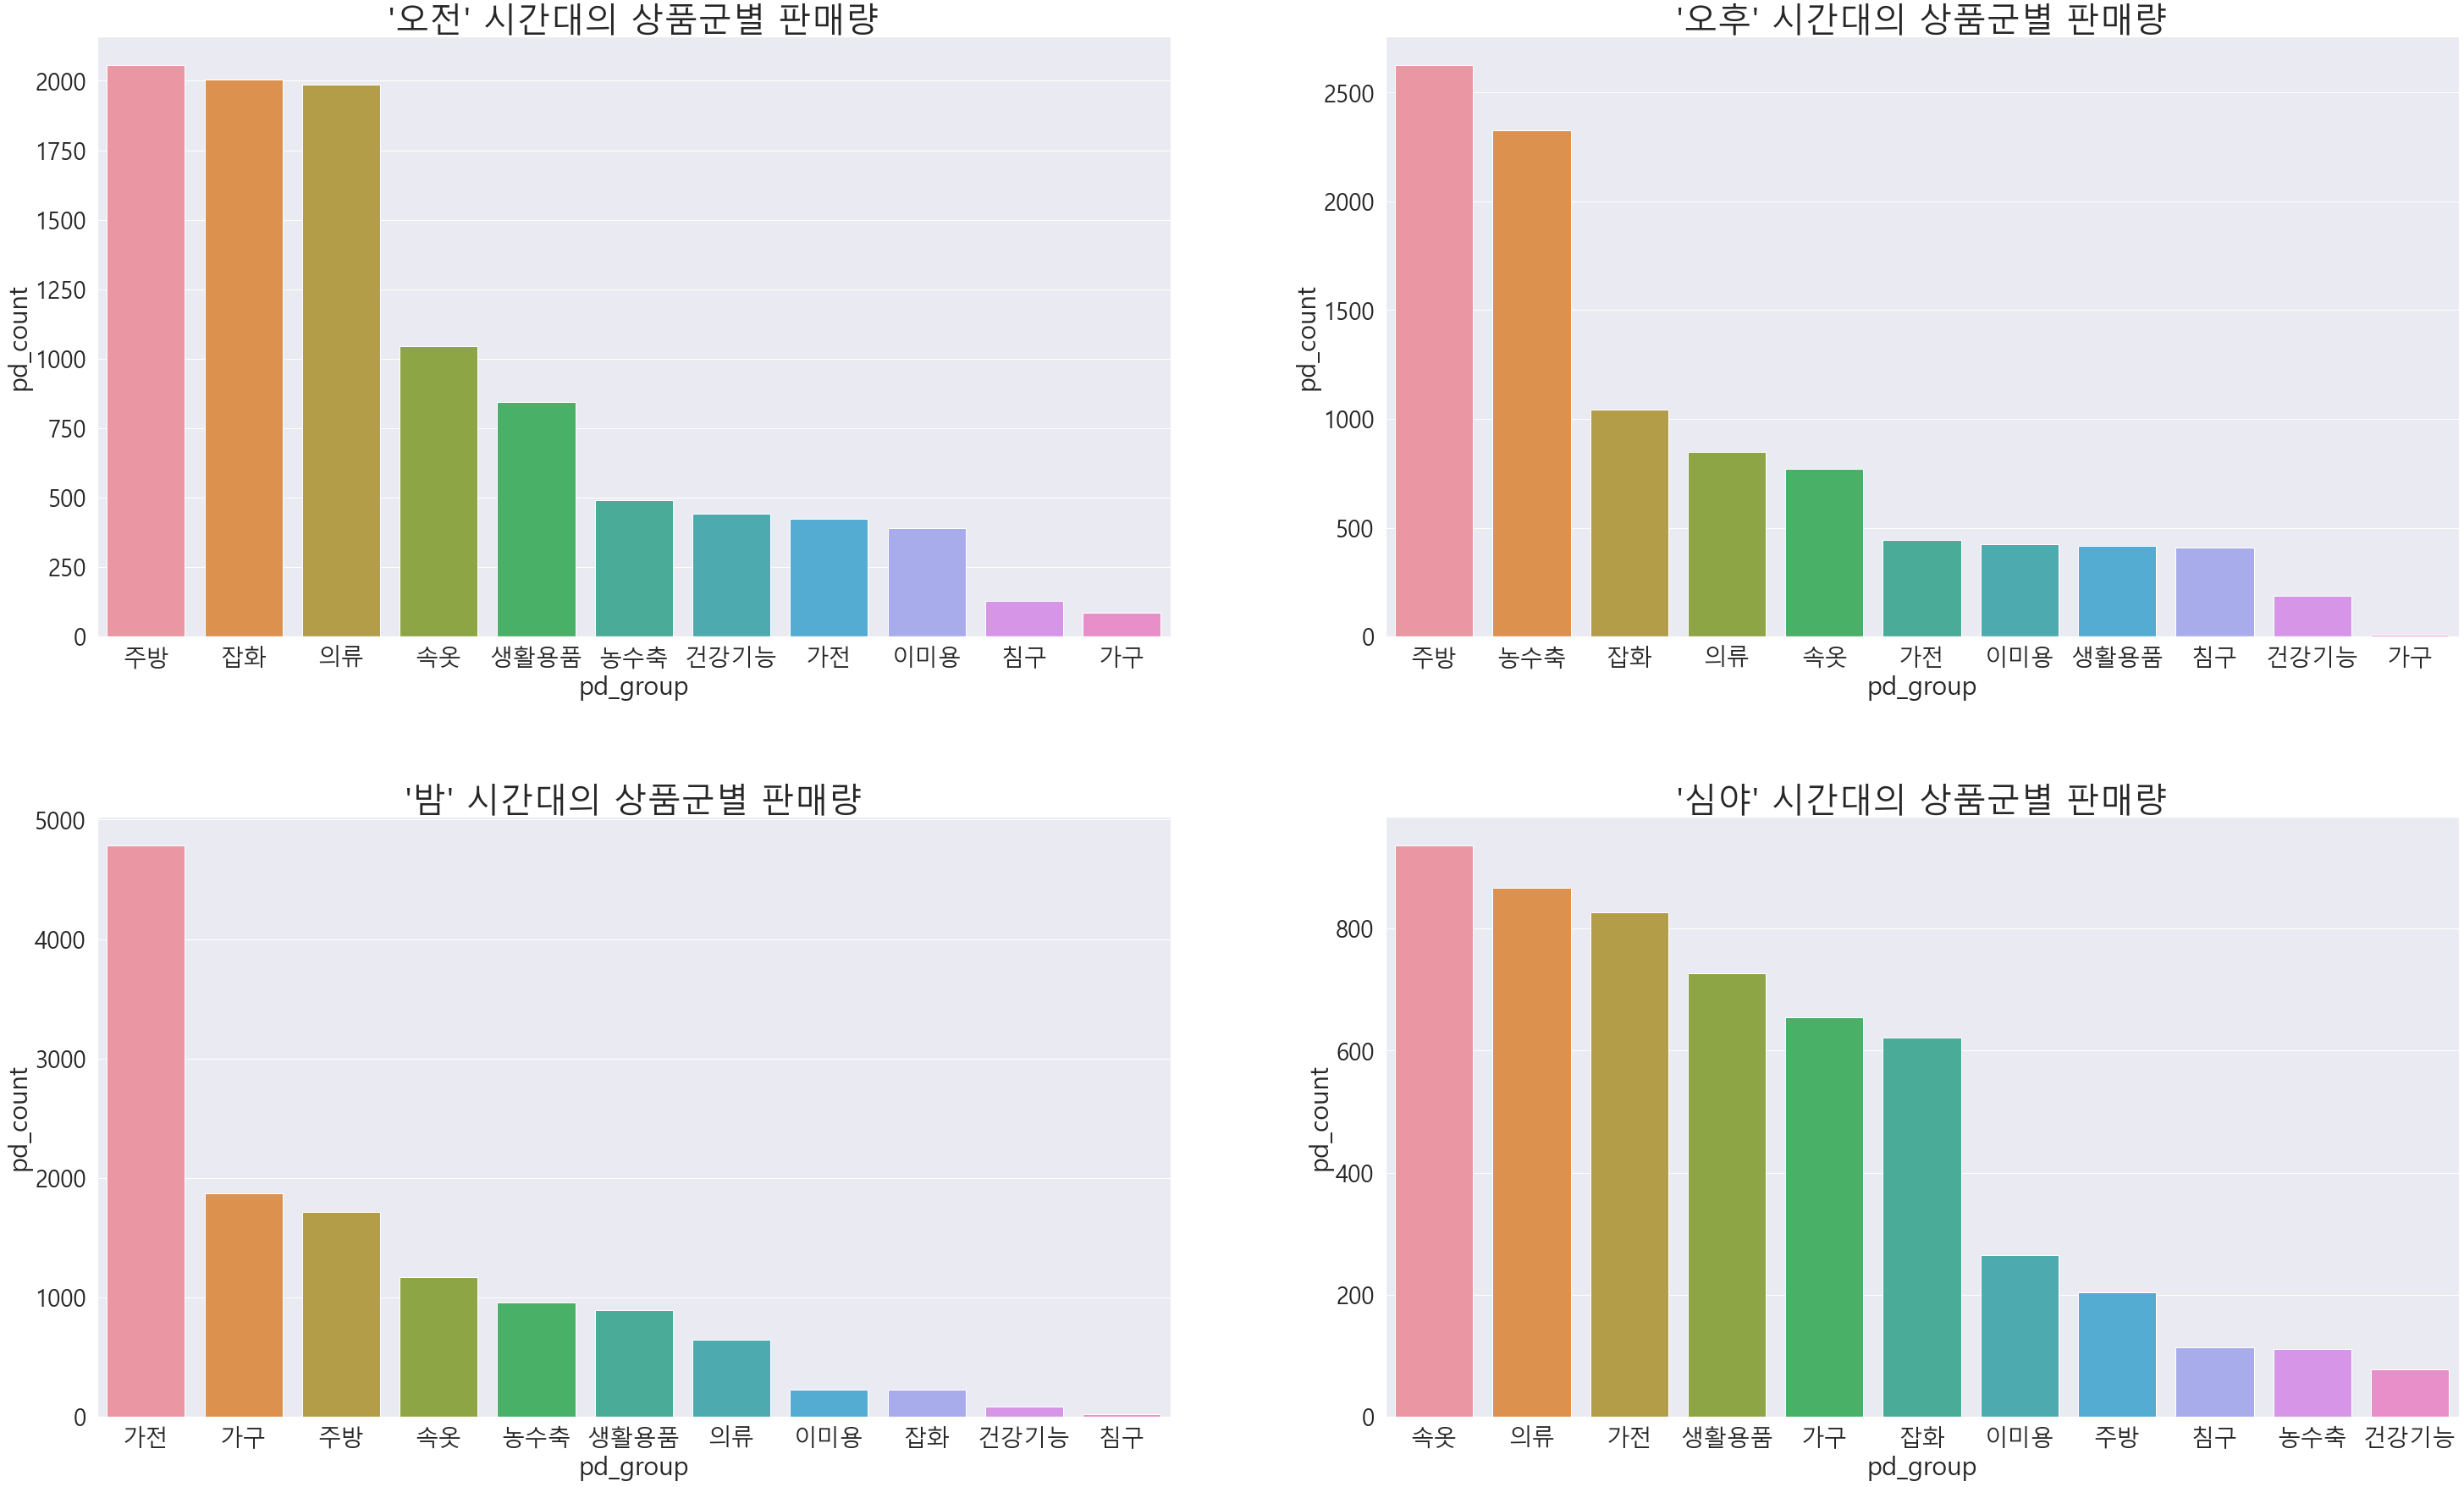

In [26]:
# 3. 범주화된 시간대별(hour_cat) 각 상품군의 판매량
f, ax = plt.subplots(2, 2)
f.set_size_inches(50, 30)

sns.countplot(data = df_morning, x = 'pd_group', ax = ax[0, 0], 
              order = df_morning['pd_group'].value_counts().index)
sns.countplot(data = df_afternoon, x = 'pd_group', ax = ax[0, 1],
              order = df_afternoon['pd_group'].value_counts().index)
sns.countplot(data = df_night, x = 'pd_group', ax = ax[1, 0],
              order = df_night['pd_group'].value_counts().index)
sns.countplot(data = df_late_at_night, x = 'pd_group', ax = ax[1, 1],
              order = df_late_at_night['pd_group'].value_counts().index)

ax[0, 0].set_title("'오전' 시간대의 상품군별 판매량", fontsize = 40)
ax[0, 1].set_title("'오후' 시간대의 상품군별 판매량", fontsize = 40)
ax[1, 0].set_title("'밤' 시간대의 상품군별 판매량", fontsize = 40)
ax[1, 1].set_title("'심야' 시간대의 상품군별 판매량", fontsize = 40)

ax[0, 0].set(ylabel = 'pd_count')
ax[0, 1].set(ylabel = 'pd_count')
ax[1, 0].set(ylabel = 'pd_count')
ax[1, 1].set(ylabel = 'pd_count')

plt.subplots_adjust(hspace = 0.3) # 각각의 subplot들이 겹치지 않도록 세로 공간을 조정
plt.show()

**<범주화된 시간대별(hour_cat) 각 상품군의 판매량>**
1. "오전" 시간대의 상품군별 판매량
    - "주방, 잡화, 의류" 상품군의 판매량이 압도적으로 높다.
2. "오후" 시간대의 상품군별 판매량
    - "주방, 농수축" 상품군의 판매량이 매우 높은 편이다.
3. "밤" 시간대의 상품군별 판매량
    - "가전" 상품군의 판매량이 압도적으로 높다.
4. "심야" 시간대의 상품군별 판매량
    - "속옷, 의류, 가전" 상품군의 판매량이 비교적 높은 편이다.

## 시간대별(hour) 월별(month)/요일별(weekdays)/계절별(seasons) 시청률 추이
- 이걸 확인해보는 것이 의미가 있을런지..?

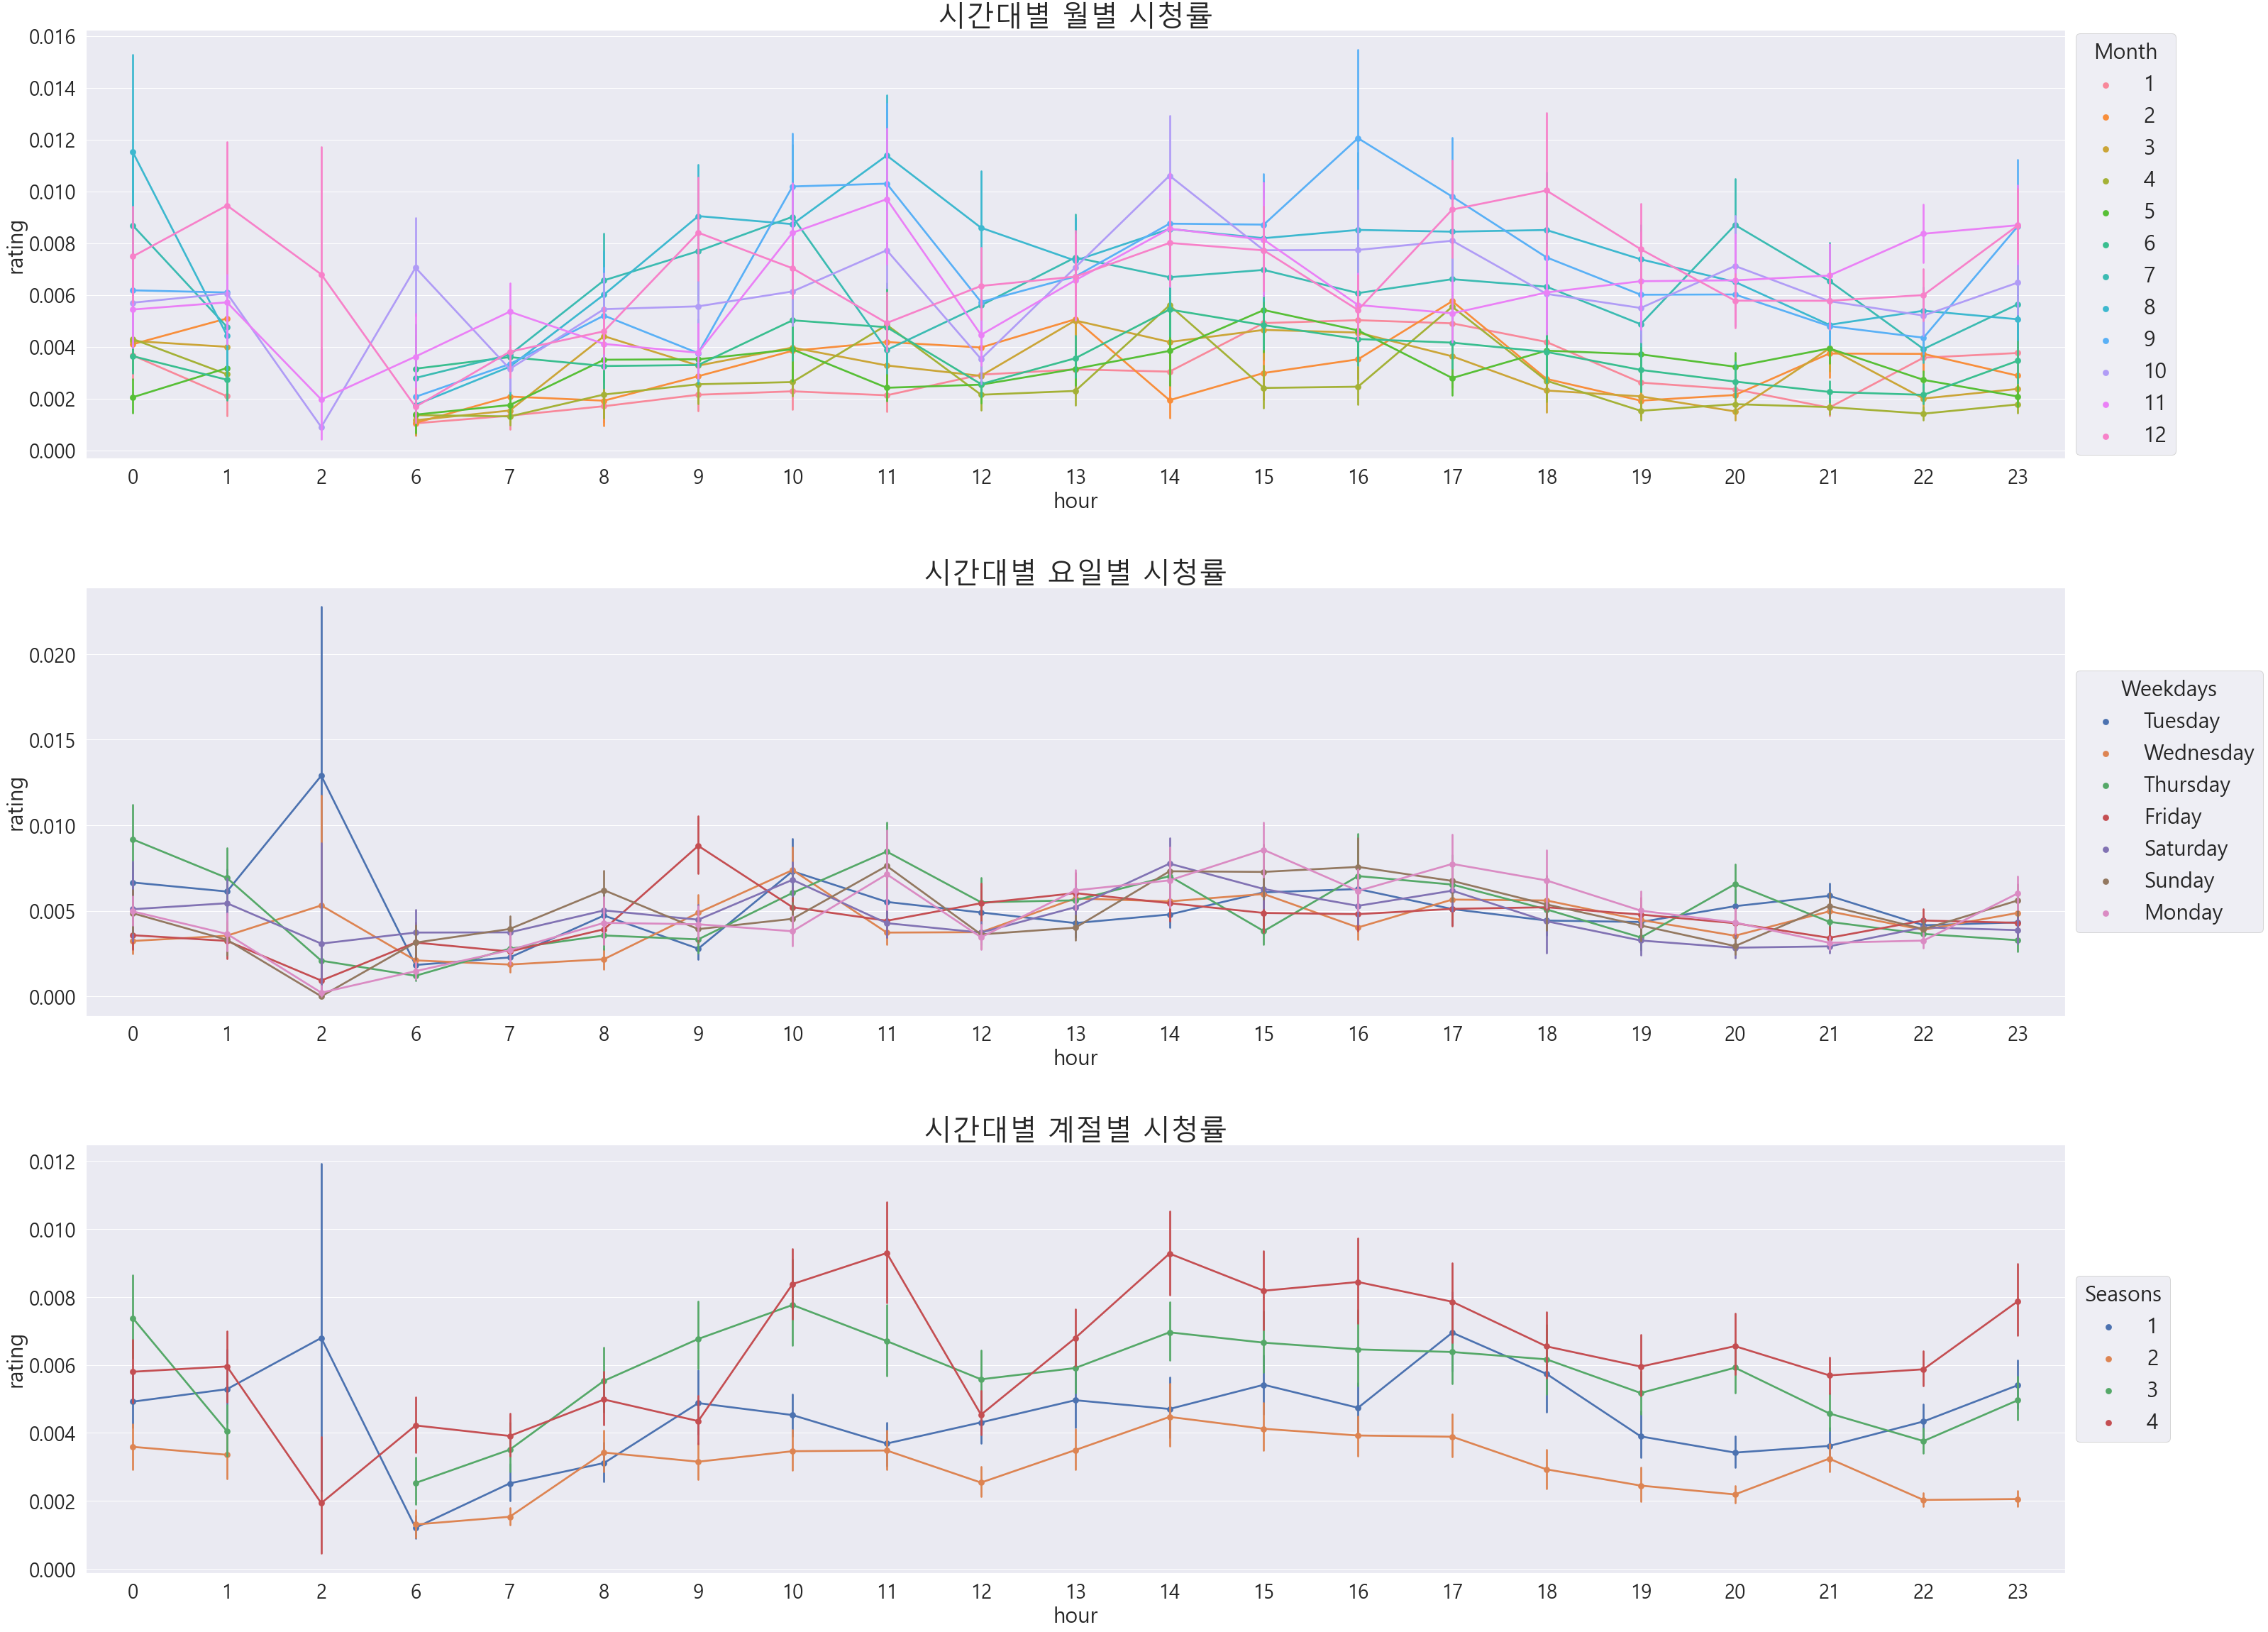

In [27]:
f,(ax1, ax2, ax3) = plt.subplots(nrows = 3)
f.set_size_inches(50, 40)

# 1. 시간대별(hour) 월별(month) 시청률
sns.pointplot(data = df_train, x = 'hour', y = 'rating', hue = 'month', ax = ax1)
# 2. 시간대별(hour) 요일별(weekdays) 시청률
sns.pointplot(data = df_train, x = 'hour', y = 'rating', hue = 'weekdays', ax = ax2)
# 3. 시간대별(hour) 계절별(seasons) 시청률
sns.pointplot(data = df_train, x = 'hour', y = 'rating', hue = 'seasons', ax = ax3)

ax1.set_title('시간대별 월별 시청률', fontsize = 40)
ax2.set_title('시간대별 요일별 시청률', fontsize = 40)
ax3.set_title('시간대별 계절별 시청률', fontsize = 40)

# legend 위치 및 사이즈 조절
ax1.legend(loc = 'center left', title = 'Month', frameon = True, bbox_to_anchor = (1, 0.5), title_fontsize = 30, fontsize = 30)
ax2.legend(loc = 'center left', title = 'Weekdays', frameon = True, bbox_to_anchor = (1, 0.5), title_fontsize = 30, fontsize = 30)
ax3.legend(loc = 'center left', title = 'Seasons', frameon = True, bbox_to_anchor = (1, 0.5), title_fontsize = 30, fontsize = 30)

plt.subplots_adjust(hspace = 0.3) # 각각의 subplot들이 겹치지 않도록 세로 공간을 조정
plt.show()

## 시청률(rating)과 다른 연속형 변수들 간의 상관관계 확인
- 상관관계를 확인해 볼 연속형 변수들(시청률 변수를 제외하고 총 9개)
    - exp_mins
    - pd_price
    - pd_count
    - sales
        - Target 변수
    - rating
    - temp
    - rain
        - (다수의) 결측값 존재
    - humidity
    - snow
        - (다수의) 결측값 존재
    - dust
        - 결측값 존재

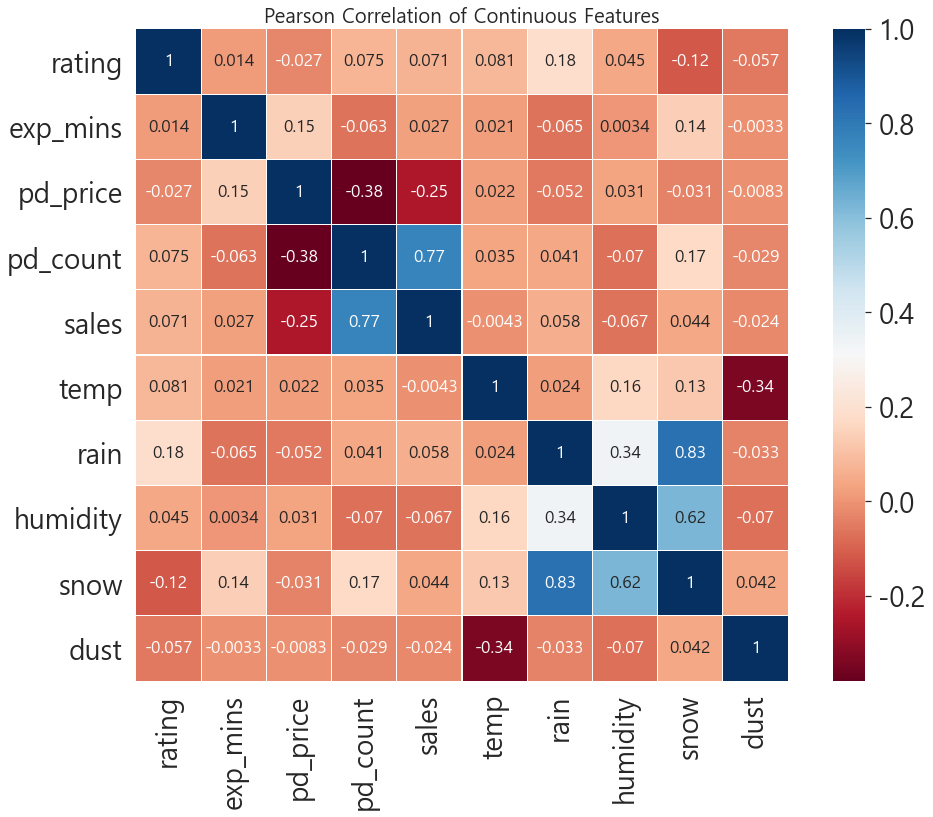

In [28]:
# 시청률과의 상관관계를 확인해 볼 연속형 변수들 (시청률 변수를 제외하고 총 9개)
corr_mat = df_train[['rating', 'exp_mins', 'pd_price', 'pd_count', 'sales', 'temp', 'rain', 'humidity', 'snow', 'dust']]

# 연속형 변수들 간의 상관계수 확인
plt.figure(figsize = (16, 12))
plt.title('Pearson Correlation of Continuous Features', size = 20)

colormap = plt.cm.RdBu
sns.heatmap(corr_mat.astype(float).corr(), cmap = colormap, 
            linewidth = 0.1, linecolor = 'white', square = True, 
            annot = True, annot_kws = {'size': 17})

- Heatmap 결과를 살펴보면 시청률 변수와 상관관계가 높은 변수들이 존재하지 않는다.
    - 특히 미세먼지 농도가 높으면 사람들이 밖에 나가는 것을 꺼려해서 시청률에 영향을 줄 것이라고 추측했었는데, 미세먼지 농도(dust)와 시청률 간의 상관계수가 -0.057 밖에 되지 않는다.
- 또한 취급액(sales)와 판매 개수(pd_count)의 상관계수가 0.77로 높은 양의 상관관계를 보이고 있다.
    - 이건 당연한 결과라서...^^;

# 추가된 파생변수들을 포함한 데이터 셋 csv 파일로 내보내기

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       37372 non-null  datetime64[ns]
 1   exp_mins   37372 non-null  float64       
 2   mom_code   37372 non-null  int64         
 3   pd_code    37372 non-null  int64         
 4   pd_name    37372 non-null  object        
 5   pd_group   37372 non-null  object        
 6   pd_price   37372 non-null  int64         
 7   sales      37372 non-null  float64       
 8   weekdays   37372 non-null  object        
 9   seasons    37372 non-null  int64         
 10  rating     37372 non-null  float64       
 11  temp       37372 non-null  float64       
 12  rain       3489 non-null   float64       
 13  humidity   37372 non-null  float64       
 14  snow       368 non-null    float64       
 15  dust       34952 non-null  float64       
 16  is_rain    37372 non-null  int64        

In [30]:
df_train.to_csv('C:/Users/82109/Desktop/Data Science/Competition/2020_Bigcontest_working/dataset/df_train_final2.csv', index = False)